
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU
* Next Cast is green line
* Saves Results to text file



## Parameters


In [1]:

vocab_size = 1000



## Experimental Details


In [2]:


exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.close()




## Libraries


In [3]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [4]:

import pandas as pd
import numpy as np


In [5]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [6]:

## import xgboost as xgb
## from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb


In [7]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [8]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score



## Univariate permutation example


In [9]:

from einops import rearrange
from math import sqrt, log


In [10]:

patch_size = 10
stride     = 4

x_enc = torch.rand( 8, 40, 24)
print( x_enc.shape )

B, L, M = x_enc.shape
print(B)
print(L)
print(M)

x_enc = rearrange(x_enc, 'b l m -> b m l')
print( x_enc.shape )

x_enc = x_enc.unfold(dimension=-1, size=patch_size, step=stride)
print( x_enc.shape )

x_enc = rearrange(x_enc, 'b m n p -> (b m) n p')
x_enc.shape


torch.Size([8, 40, 24])
8
40
24
torch.Size([8, 24, 40])
torch.Size([8, 24, 8, 10])


torch.Size([192, 8, 10])


## Positional Encoding example


In [11]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe


In [12]:

res = PositionalEncoding(15, 512, normalize=True)
res.shape


torch.Size([15, 512])

In [13]:

device = "cpu"


In [14]:

x_enc = torch.rand( 8, 15, 512)
print( x_enc.shape )


torch.Size([8, 15, 512])


In [15]:

pos_emb_table_rc         = nn.Embedding(15, 512)     ## [15, 512]


In [16]:

torch.arange(15, device=device)



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [17]:

pos_emb = pos_emb_table_rc( torch.arange(15, device=device) ) 


In [18]:

pos_emb.shape


torch.Size([15, 512])

In [19]:

res = x_enc + pos_emb


In [20]:

res.shape


torch.Size([8, 15, 512])


## Moving Avg example


In [21]:

'''

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x

'''


'\n\nclass moving_avg(nn.Module):\n\n    def __init__(self, x):\n        \n        super().__init__()\n        \n        self.kernel_size = x.shape[2]\n        self.stride      = 1\n        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)\n\n    def forward(self, x):\n        \n\n        x = self.avg( x )         ## x.permute(0, 2, 1))\n        \n        ## x = x.permute(0, 2, 1)\n        \n        return x\n\n'

In [22]:

'''

x_enc = torch.rand( 8, 40, 5)

print( x_enc.shape )

obj_mov_avg = moving_avg( x_enc  )

res = obj_mov_avg( x_enc )

print( x_enc[1, 2, :])

ans = x_enc - res

print( ans[1, 2, :])

print( ans.shape )

'''



'\n\nx_enc = torch.rand( 8, 40, 5)\n\nprint( x_enc.shape )\n\nobj_mov_avg = moving_avg( x_enc  )\n\nres = obj_mov_avg( x_enc )\n\nprint( x_enc[1, 2, :])\n\nans = x_enc - res\n\nprint( ans[1, 2, :])\n\nprint( ans.shape )\n\n'


## Read the data


In [23]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [24]:

for_RNN_data_CIVS


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0              1  0.719500                4.242439          2161.425209   
1              2  0.710486                4.174343          2168.238915   
2              3  0.666106                4.126144          2167.779119   
3              4  0.675145                4.120736          2166.974740   
4              5  0.776831                4.120331          2166.384674   
...          ...       ...                     ...                  ...   
1378        1379  0.762500                4.204430          2169.361647   
1379        1380  0.646000                4.208539          2169.079601   
1380        1381  0.654667                4.212648          2168.797556   
1381        1382  0.591667                4.217784          2168.444999   
1382        1383  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SE_Uptake_f3  NW_Uptake_f3  \
0              0.354        0.16  ...    182.533770    148.126483   
1              0.313        0.83  ...    183.725050    148.161842   
2              0.360        0.10  ...    195.812061    147.562523   
3              0.319        0.34  ...    188.028883    147.807509   
4              0.335        0.28  ...    200.141261    149.014319   
...              ...         ...  ...           ...           ...   
1378           0.343        0.30  ...    185.900341    148.103530   
1379           0.324        0.30  ...    182.408576    148.106012   
1380           0.325        0.16  ...    181.684649    148.108493   
1381           0.335        0.26  ...    195.202191    148.111595   
1382           0.328        1.08  ...    220.149599    148.115317   

      SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       192.512412     37.369999    36.439999         9.86   
1       192.366046     35.540001    35.970001         9.03   
2       198.423474     34.849998    36.590000         9.13   
3       179.116839     34.009998    35.900002         8.82   
4       186.052137     34.380001    35.970001         8.73   
...            ...           ...          ...          ...   
1378    199.914193     35.900002    37.259998        10.04   
1379    193.501805     35.900002    37.259998        10.04   
1380    194.328694     35.580002    36.500000         9.30   
1381    215.606202     35.130001    37.470001        10.01   
1382    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...           ...                    ...   
1378                98.334297     18.209401              36.727897  

In [25]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [26]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [27]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [28]:

for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Plots


In [29]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

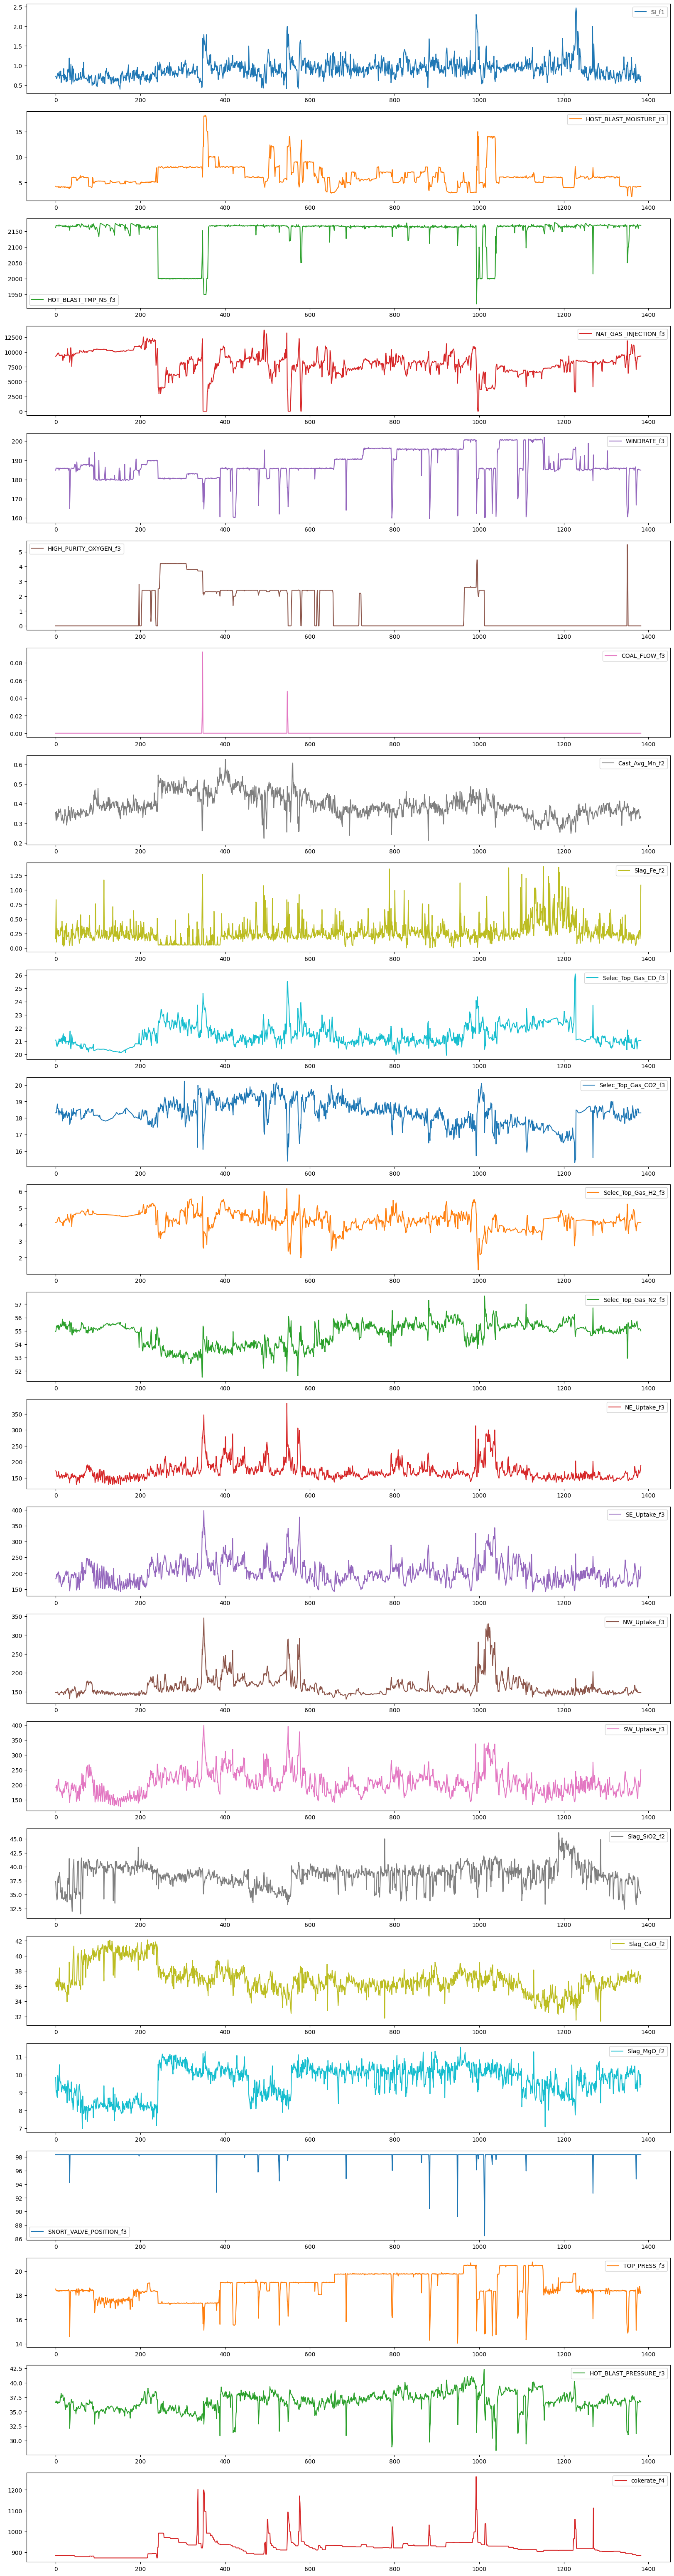

In [30]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [31]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [32]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [33]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [34]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [35]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [36]:

'''

train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )

train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs

bt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )

bt_train_x.shape

bt_train_y.shape

x_means

'''


'\n\ntrain_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )\n\ntrain_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs\n\nbt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )\n\nbt_train_x.shape\n\nbt_train_y.shape\n\nx_means\n\n'


## Estimate loss - No Training


In [37]:

@torch.no_grad()    ## for efficient processing
def estimate_loss( model, criterion ):
    
    out = {}
    model.eval()   ## set to no training
    
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range( eval_iters ):
            X, Y = get_batch( split )
            logits  = model(X, Y)
            B, T, E  = logits.shape
            pred     = logits.view( B*T, E)
            y_train  = Y.view(B*T, E)
            loss =  criterion( pred, y_train )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training

    return out



## NN Architectures


In [38]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512] or [B, 15, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [39]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [40]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [41]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [42]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x_avg = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)

        x = x + x_avg
        
        return x


In [43]:

m = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
input2 = torch.randn(8, 4, 25)

input_permute = rearrange(input2, 'b l m -> b m l')
print( input_permute.shape )
input2 = input2.unsqueeze(1)
input_permute = input_permute.unsqueeze(1)
output = m(input_permute)
output.shape


torch.Size([8, 25, 4])


torch.Size([8, 1, 25, 4])

In [44]:

inputs = torch.randn( 64, 1, 300 ) 

module = torch.nn.Conv1d(
    in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False
)

## module.weight.data = torch.full_like( module.weight.data, 0.2 )

out = module(inputs)
out.shape


torch.Size([64, 1, 300])

In [45]:

## a = torch.tensor( 42.6 )

## torch.round(a).int().item()


In [46]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size = output_size
        self.seq_length  = seq_length       ## 40 or 15
        self.input_size  = input_size

        vocab_size = 30
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512] or [40, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 25)  ## [512, 65] # FFW Layer

        #######################################################################

        self.map_24_512 = nn.Linear(25, 512)  ## [24, 512] # projection
        self.map_act    = nn.ReLU()

        #######################################################################

        self.map_24_512_1 = nn.Linear(25, 100)  ## [24, 512] # projection
        self.map_act1     = nn.ReLU()
        self.LayerNorm1   = nn.LayerNorm( 100 )
        self.map_24_512_2 = nn.Linear(100, 512)  ## [24, 512] # projection
        
   
        #####################################

        self.linear1_TS_int = nn.Linear(25, 15)
        self.act1_TS_int    = nn.ReLU()
        self.linear2_TS_int = nn.Linear(15, 9)
        self.act2_TS_int    = nn.ReLU()
        self.linear3_TS_int = nn.Linear(9, vocab_size)
        self.act3_TS_int    = nn.Softmax(dim=1)
        self.dropout_TS_int = nn.Dropout(0.25)
        
        #####################################

        self.conv_idx     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.per_conv_idx = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
        #####################################
        

    def forward(self,  idx, targets):

        ## print( idx.shape      )
        ## print( targets.shape  )
        ######################

        ## obj_mov_avg = moving_avg(  idx  )
        ## res         = obj_mov_avg( idx )
        ## idx = res

        #####################

        B = idx.shape[0]       ## 8 batch 
        T = idx.shape[1]       ## 40 or 15

        ############################################################
        ## add this back - rc

        ## idx = self.map_24_512( idx )       ## (8, 15, 24) goes in
        ## idx = self.map_act(    idx )
        
        ## tok_emb = idx       ## (B, 15, 512)

        ###########################################################

        idx = self.map_24_512_1( idx )       ## (8, 15, 24) goes in
        idx = self.map_act1(     idx )
        idx = self.LayerNorm1(   idx )
        idx = self.map_24_512_2( idx ) 
        
        tok_emb = idx       ## (B, 15, 512)

        ###########################################################
        ## convolutions

        idx_4d_conv = idx.unsqueeze(1)
        
        conv_emb = self.conv_idx( idx_4d_conv )
        conv_emb = conv_emb.squeeze(1)
        

        ## Permute
        idx_4d_conv_permute = rearrange(idx_4d_conv, 'b c l m -> b c m l')
        per_conv_emb = self.per_conv_idx( idx_4d_conv_permute )
        per_conv_emb = rearrange(per_conv_emb, 'b c m l -> b c l m')
        per_conv_emb = per_conv_emb.squeeze(1)

        ###########################################################
        
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        
        ## pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sines and cosines

        ###########################################################
        
        ## x = tok_emb + pos_emb + conv_emb + per_conv_emb    ## [B, T, E] or [N, 40, 512], now [N, 15, 24]

        x = conv_emb + pos_emb 

        ############################################################
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65]  or [N, 15, 24]
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            logits = self(idx_cond, 0 )    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            
        return idx
            



## Train GPT function


In [47]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 25, 25)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )

    criterion          = nn.MSELoss()
    ## criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': []}
    
    train_CIVS_tr, x_means, x_standard_devs    = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        xb, yb    = get_batch( train_CIVS_tr_scaled )

        logits   = model( xb, yb )

        B, T, E  = logits.shape
        
        pred           = logits.view( B*T, E )
        y_train        = yb.view(     B*T, E )

        #######################################################
        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        ## loss = criterion( pred[:, 0], y_train[:, 0]  )
        #######################################################

        loss =  criterion( pred, y_train )      ## seems better
        
        optimizer.zero_grad( set_to_none=True )          
        loss.backward()
        optimizer.step()

        history['loss'].append(  loss.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item() )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [48]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ##   40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 3000   ## 5000
eval_interval     = 500     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512       ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2

comment_exp       = "None"



## Utility Functions


In [49]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()       ## pandas to torch

    x_time_series = test_data

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [50]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae  = MAE( pred, true)
    mse  = MSE( pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse  = RSE( pred, true)

    return mae, mse, rmse, mape, mspe, rse      


In [51]:

def GPT_generate_inference(model, x_test, which_feature, string_feature, train_CIVS_2_a ):

    xb_test, yb_test = GPT_get_batch_test( x_test )

    input_test_x = xb_test[ :,  : 5 ]         ## give first 4 in sequence for GPT to generate the rest
    
    pred_20_seq = model.generate( input_test_x, 14 )

    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 
    
    find_index = index_to_slice + 395
    SI_data    = SI_lookup_for_RNN_data_CIVS.to_numpy()[ find_index:find_index+19, 0 ]  ## real SI data is here

    y_real_gpt = y_real_gpt.squeeze(0)
    y_pred_gpt = y_pred_gpt.squeeze(0)

    l_real = y_real_gpt[ :, 0 ]   
    l_pred = y_pred_gpt[ :, 0 ]

    l_SI_data_real = SI_data
    si_mean         = x_means[0, 0].numpy()
    si_standard_dev = x_standard_devs[0, 0].numpy()

    ##################################################

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]
    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()
    l_pred_all_24_features        = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features        = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features

    ##################################################
    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    
    l_pred        = l_pred   * si_standard_dev   + si_mean
    l_real        = l_real   * si_standard_dev   + si_mean

    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    mse_eval_bins0_5 = eval_criterion(
                          torch.FloatTensor( l_pred[0:4] ), 
                          torch.FloatTensor( l_real[0:4] )
    )

    mse_eval_bins5_10 = eval_criterion(
                          torch.FloatTensor( l_pred[5:10] ), 
                          torch.FloatTensor( l_real[5:10] )
    )

    mse_eval_bins10_15 = eval_criterion(
                          torch.FloatTensor( l_pred[10:19] ), 
                          torch.FloatTensor( l_real[10:19] )
    )

    ###################################################
    
    metric_mse_loss_SI_only                = mse_eval_bins.item()
    metric_mae_mse_rmse_mape_mspe_rse_corr = metric(    l_pred, l_real ) 
    metric_rsquare_SI_only                 = r2_score(  l_real, l_pred )
    metric_rsquare_all_features            = r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
    ) 

    #####

    results_string = "mse_SI_only," + str(round( metric_mse_loss_SI_only, 4)) 
    results_string = results_string + "," + "rsquare_SI_only" + "," + str(round( metric_rsquare_SI_only, 4))
    results_string = results_string + "," + "rsquare_all_features" + "," + str(round( metric_rsquare_all_features, 4))
    several_metrics = str( metric_mae_mse_rmse_mape_mspe_rse_corr ).replace("(", "").replace(")","")
    results_string = results_string + "," + "mae_mse_rmse_mape_mspe_rse"  + "," + several_metrics
    
    ###################################################

    print( string_feature )
    print("Test MSE Loss - SI only: ",        mse_eval_bins.item()         )     ## :.4f }')
    print("Test MSE Loss - SI only 0-5: ",    mse_eval_bins0_5.item()      )     ## :.4f }')
    print("Test MSE Loss - SI only 5-10: ",   mse_eval_bins5_10.item()     )     ## :.4f }')
    print("Test MSE Loss - SI only 10-15: ",  mse_eval_bins10_15.item()    )     ## :.4f }')
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric_mae_mse_rmse_mape_mspe_rse_corr    )
    print( "Testing R**2 - SI only: ", metric_rsquare_SI_only  )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    
    print( "Testing R**2 - All features: ", metric_rsquare_all_features )

    #######################################

    x = [ i for i in range(len(l_real)) ] 

    l_SI_data_pred = []
    ## www3 = SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    www3 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    the_curr_val = www3            ##l_SI_data_real[0]  ### www3
    for i in range( len(l_pred) ):
        the_curr_val = the_curr_val + l_pred[i]
        l_SI_data_pred.append( the_curr_val )

    ########################################

    yellow_l_SI_data_pred = []
    for i in range( len(l_pred) ):
        ww4 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1 + i, 0]
        the_curr_val = ww4 + l_pred[i]
        yellow_l_SI_data_pred.append( the_curr_val )

    ########################################
    ## Plots

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    plt.plot(   x, l_SI_data_real, label = "real", color='red') 
    
    l_pred = np.roll(l_pred, -1)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_SI_data_pred, label = "pred", color='blue') 
    plt.plot(   x, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow
    
    plt.legend() 
    plt.show()

    ##########################################

    train_plot = torch.tensor(train_CIVS_2_a.values).float().numpy()
    train_real_plot = train_plot[:, 0]
    l_real  = np.concatenate( ( train_real_plot, l_real ) )
    l_pred  = np.concatenate( ( train_real_plot, l_pred ) )
    
    ##########################################

    x = [ i for i in range(len(l_real)) ] 

    x_delta = [ i for i in range(len(l_SI_data_real)) ] 

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    ##ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ##ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].scatter(x, l_real, label = "real", color='red') 
    ax[0].plot(   x, l_real, label = "real", color='red') 
    ax[0].scatter(x, l_pred, label = "pred", color='blue') 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') 
    ax[0].legend()

    ###########################################
    
    ax[1].set_title(f"GPT")
    ax[1].scatter(x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].plot(   x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].scatter(x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow  ## ?? rc
    fig.tight_layout()
    ax[1].legend(); plt.show()

    return results_string 


In [52]:

def function_train_rc(  train_data  ):
    
    train_CIVS_2 = train_data
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].legend()
    ax[1].set_title(f"GPT")

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [53]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    
    train_CIVS_2 = train_data
    
    print(  test_CIVS.shape )
    print( train_data.shape )
    ## print( train_data[ -5: ] )

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    print( test_CIVS_concat.shape )

    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    print(  test_CIVS_tr_scaled.shape )

    batch_x_test = test_CIVS_tr_scaled
    print( batch_x_test.shape )
    results_string = GPT_generate_inference(   si_GPT,  batch_x_test, 0 , "SI", train_CIVS_2 )
    return results_string


In [54]:

'''
SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]
print(SI_data.shape)
SI_data
'''


'\nSI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]\nprint(SI_data.shape)\nSI_data\n'


## The Data


In [55]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0


## Delta of SI


In [56]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [57]:

delta_for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [58]:

delta_for_RNN_data_CIVS.insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [59]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [60]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0            0  0.719500                4.242439          2161.425209   
1            0  0.710486                4.174343          2168.238915   
2            0  0.666106                4.126144          2167.779119   
3            0  0.675145                4.120736          2166.974740   
4            0  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378         0  0.762500                4.204430          2169.361647   
1379         0  0.646000                4.208539          2169.079601   
1380         0  0.654667                4.212648          2168.797556   
1381         0  0.591667                4.217784          2168.444999   
1382         0  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [61]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [62]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000  0.719500                4.242439          2161.425209   
1     0.000000  0.710486                4.174343          2168.238915   
2    -0.044380  0.666106                4.126144          2167.779119   
3     0.009040  0.675145                4.120736          2166.974740   
4     0.101686  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378  0.109500  0.762500                4.204430          2169.361647   
1379 -0.116500  0.646000                4.208539          2169.079601   
1380  0.008667  0.654667                4.212648          2168.797556   
1381 -0.063000  0.591667                4.217784          2168.444999   
1382  0.133000  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [63]:

l_delta = ['delta_SI',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [64]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [65]:

delta_for_RNN_data_CIVS


delta_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000                4.242439          2161.425209   
1     0.000000                4.174343          2168.238915   
2    -0.044380                4.126144          2167.779119   
3     0.009040                4.120736          2166.974740   
4     0.101686                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.109500                4.204430          2169.361647   
1379 -0.116500                4.208539          2169.079601   
1380  0.008667                4.212648          2168.797556   
1381 -0.063000                4.217784          2168.444999   
1382  0.133000                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       14

In [66]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [67]:


delta_for_RNN_data_CIVS .insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [68]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000           0                4.242439          2161.425209   
1     0.000000           0                4.174343          2168.238915   
2    -0.044380           0                4.126144          2167.779119   
3     0.009040           0                4.120736          2166.974740   
4     0.101686           0                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500           0                4.204430          2169.361647   
1379 -0.116500           0                4.208539          2169.079601   
1380  0.008667           0                4.212648          2168.797556   
1381 -0.063000           0                4.217784          2168.444999   
1382  0.133000           0                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [69]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [70]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [71]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000    0.000000                4.242439          2161.425209   
1     0.000000    0.000000                4.174343          2168.238915   
2    -0.044380    0.000000                4.126144          2167.779119   
3     0.009040    0.000000                4.120736          2166.974740   
4     0.101686    0.000000                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500    0.004444                4.204430          2169.361647   
1379 -0.116500    0.008900                4.208539          2169.079601   
1380  0.008667   -0.037618                4.212648          2168.797556   
1381 -0.063000   -0.014340                4.217784          2168.444999   
1382  0.133000    0.011422                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [72]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Pick slice randomly


In [73]:

training_chunk = 400


In [74]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n


1383


## Run 1


In [75]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


725

In [76]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


1383
725
1140


In [77]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [78]:

sliced_chunk_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
725  -0.103202    0.010625                5.536534          2161.974603   
726   0.098396   -0.002454                5.481241          2166.024544   
727   0.034680    0.014791                5.443307          2165.795630   
728  -0.278897   -0.027545                5.492475          2164.303546   
729   0.060988   -0.019269                5.540408          2156.971076   
...        ...         ...                     ...                  ...   
1135  0.006179   -0.029507                5.069940          2162.730872   
1136  0.189314   -0.041172                5.047143          2164.659326   
1137 -0.095665   -0.001167                5.031754          2167.638618   
1138 -0.036761    0.011441                4.965069          2166.147467   
1139  0.034564    0.029621                4.964201          2164.366813   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
725             8106.525530   192.723246                    0.0           0.0   
726             8151.768412   192.586605                    0.0           0.0   
727             8456.407551   195.931840                    0.0           0.0   
728             8723.420255   196.027285                    0.0           0.0   
729             8620.483081   196.430777                    0.0           0.0   
...                     ...          ...                    ...           ...   
1135            6529.327644   200.577082                    0.0           0.0   
1136            6725.064262   200.716122                    0.0           0.0   
1137            6578.057543   200.469006                    0.0           0.0   
1138            6581.626502   200.912450                    0.0           0.0   
1139            6570.591448   200.653035                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
725            0.372        0.24            20.662259             18.289012   
726            0.355        0.21            20.931252             18.347168   
727            0.376        0.16            20.873508             18.378326   
728            0.372        0.24            21.161466             18.378578   
729            0.341        0.37            21.219012             18.477061   
...              ...         ...                  ...                   ...   
1135           0.301        0.65            22.142438             17.457597   
1136           0.314        0.67            21.873782             17.682806   
1137           0.303        0.43            21.932342             17.550376   
1138           0.291        0.78            22.177056             17.404902   
1139           0.302        0.44            22.354280             17.377593   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
725              3.976340            55.891011    146.030156    156.919852   
726              4.009576            55.580902    147.777848    165.628174   
727              4.063958            55.671592    152.252768    173.692636   
728              4.173898            55.190041    149.854298    165.975084   
729              4.207445            55.086370    151.979279    174.139624   
...                   ...                  ...           ...           ...   
1135             3.582914            55.537931    157.439760    200.338686   
1136             3.524384            55.693235    161.019600    194.007859   
1137             3.516463            55.785456    166.221377    191.694552   
1138             3.516900            55.655115    164.556475    194.158992   
1139             3.530105            55.549074    152.254364    170.663886   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
725     144.955183    163.410632     39.080002    35.860001        10.32   
726     147.746943    163.518075     39.189999    36.400002        10.48   
727     147.859677


## Train and test


In [79]:

n = block_size

print( n )


15


In [80]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [81]:

print( train_CIVS.shape )
print( test_CIVS.shape )


(400, 25)
(15, 25)


In [82]:

test_CIVS 


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
1125  0.095000    0.013479                6.198409          2165.626244   
1126  0.305963    0.055852                6.595918          2169.050944   
1127 -0.495713   -0.008435                6.052692          2165.386745   
1128 -0.162836   -0.022020                6.627762          2170.361212   
1129 -0.147237   -0.052589                6.927008          2165.062547   
1130  0.082942   -0.020950                6.643783          2166.356603   
1131 -0.009301   -0.032092                5.729760          2164.617365   
1132  0.149105   -0.002175                5.159466          2164.273856   
1133  0.062078   -0.017800                5.141612          2164.717711   
1134 -0.086247   -0.020625                5.000737          2165.058965   
1135  0.006179   -0.029507                5.069940          2162.730872   
1136  0.189314   -0.041172                5.047143          2164.659326   
1137 -0.095665   -0.001167                5.031754          2167.638618   
1138 -0.036761    0.011441                4.965069          2166.147467   
1139  0.034564    0.029621                4.964201          2164.366813   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
1125            6677.761714   200.621788                    0.0           0.0   
1126            6781.560804   199.259117                    0.0           0.0   
1127            6152.636171   200.519146                    0.0           0.0   
1128            6831.388378   199.584915                    0.0           0.0   
1129            5734.264403   200.728645                    0.0           0.0   
1130            6766.035281   200.530591                    0.0           0.0   
1131            6721.066728   200.686818                    0.0           0.0   
1132            6666.592685   200.860153                    0.0           0.0   
1133            6586.003019   200.629533                    0.0           0.0   
1134            6549.671293   201.117520                    0.0           0.0   
1135            6529.327644   200.577082                    0.0           0.0   
1136            6725.064262   200.716122                    0.0           0.0   
1137            6578.057543   200.469006                    0.0           0.0   
1138            6581.626502   200.912450                    0.0           0.0   
1139            6570.591448   200.653035                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
1125           0.331        0.56            21.930458             17.892805   
1126           0.332        0.70            22.875366             17.254177   
1127           0.365        0.33            22.229320             17.796827   
1128           0.329        0.40            22.869710             17.254980   
1129           0.294        0.21            22.907861             17.601065   
1130           0.284        0.38            22.805602             17.251579   
1131           0.268        1.03            22.637568             17.258328   
1132           0.293        0.76            22.173976             17.477549   
1133           0.307        1.03            22.112397             17.424244   
1134           0.319        1.00            22.276440             17.376489   
1135           0.301        0.65            22.142438             17.457597   
1136           0.314        0.67            21.873782             17.682806   
1137           0.303        0.43            21.932342             17.550376   
1138           0.291        0.78            22.177056             17.404902   
1139           0.302        0.44            22.354280             17.377593   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
1125             3.563618            55.582290    160.654096    198.277721   
1126             3.871996            55.099983    136.688921    141.192433   
1127     

In [83]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [84]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


(100, 25)
(200, 25)
(300, 25)
(400, 25)


In [85]:
'''
print(idx.shape)
        vals, indeces = torch.max( idx, dim=2  )
        print( vals.shape )
        print( indeces )
        print(idx.shape)
        input()
'''

'\nprint(idx.shape)\n        vals, indeces = torch.max( idx, dim=2  )\n        print( vals.shape )\n        print( indeces )\n        print(idx.shape)\n        input()\n'

torch.Size([100, 25])
0 train loss =  0.9394303560256958
500 train loss =  0.017737725749611855
1000 train loss =  0.008146125823259354
1500 train loss =  0.0047265333123505116
2000 train loss =  0.0037853640969842672
2500 train loss =  0.0034788819029927254


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


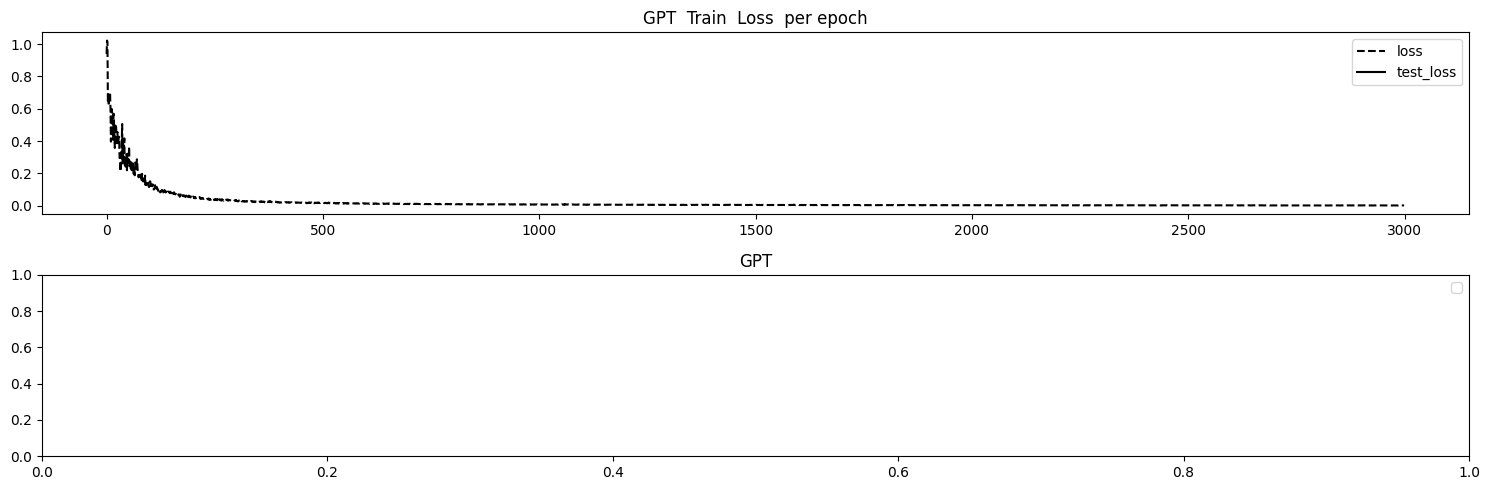

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04507054015994072
Test MSE Loss - SI only 0-5:  0.09707023948431015
Test MSE Loss - SI only 5-10:  0.07622117549180984
Test MSE Loss - SI only 10-15:  0.0070604970678687096
mae, mse, rmse, mape, mspe, rse, corr
(0.1672936, 0.045070544, 0.21229824, 1.8562582, 6.0401797, 1.2272025)
Testing R**2 - SI only:  -0.5060259543419035
Testing R**2 - SI only:  -0.5060259543419035
Testing R**2 - All features:  0.9972501545757855


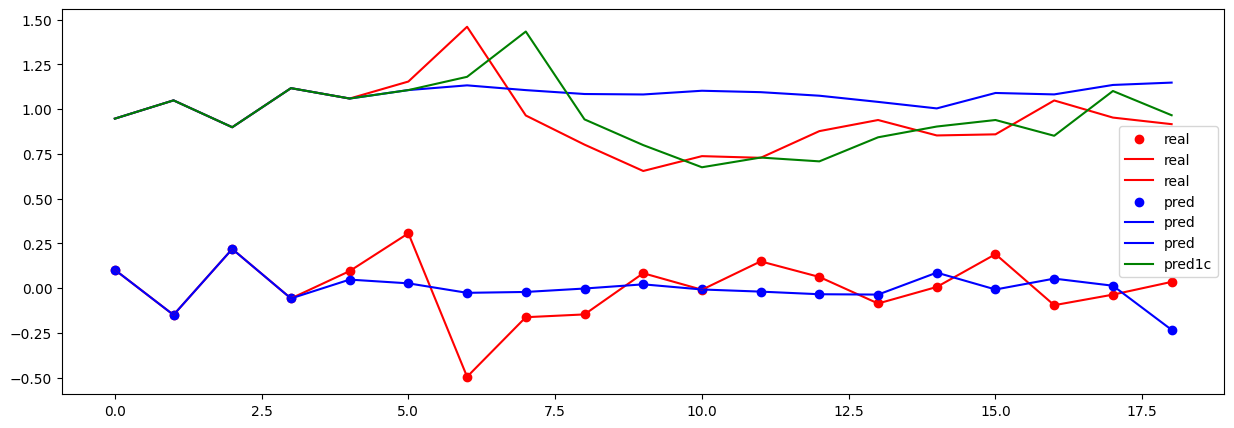

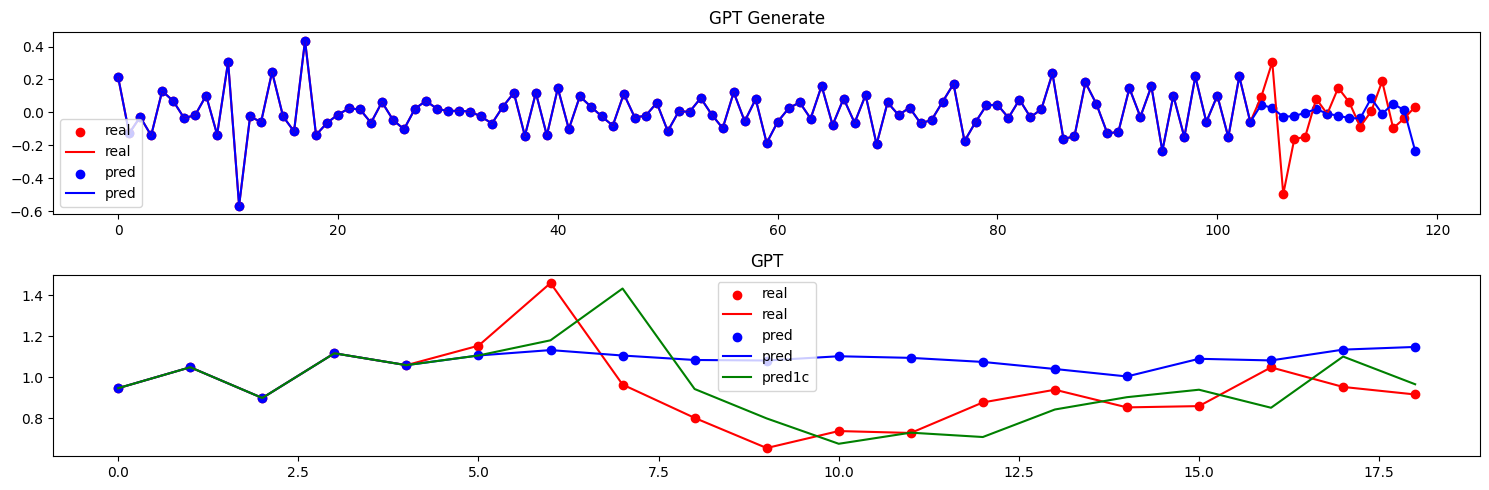

In [86]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.6392555236816406
500 train loss =  0.052457310259342194
1000 train loss =  0.020646139979362488
1500 train loss =  0.012084167450666428
2000 train loss =  0.008455950766801834
2500 train loss =  0.005757188890129328


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


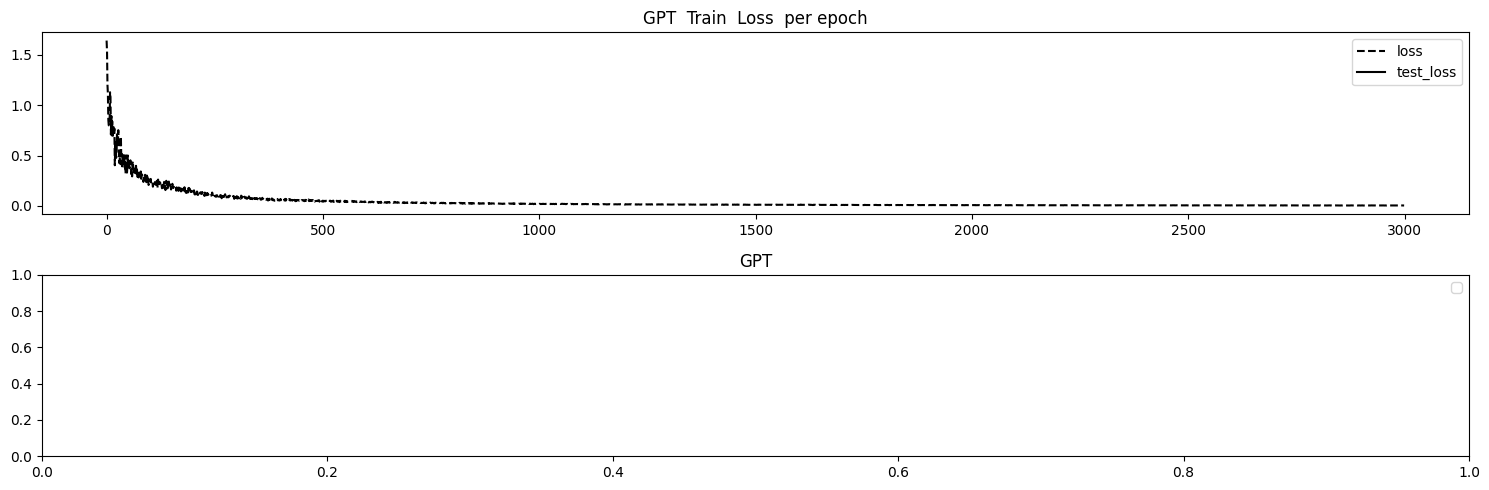

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04677645489573479
Test MSE Loss - SI only 0-5:  0.09707023948431015
Test MSE Loss - SI only 5-10:  0.07710080593824387
Test MSE Loss - SI only 10-15:  0.010173182003200054
mae, mse, rmse, mape, mspe, rse, corr
(0.18026108, 0.046776455, 0.21627866, 2.1564274, 7.838393, 1.2502115)
Testing R**2 - SI only:  -0.563028823401226
Testing R**2 - SI only:  -0.563028823401226
Testing R**2 - All features:  0.9972101850402685


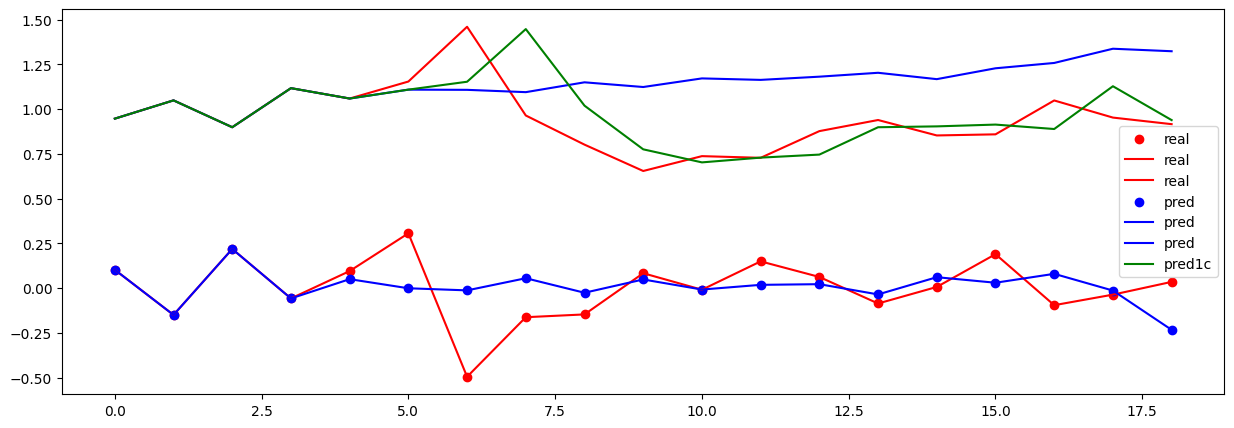

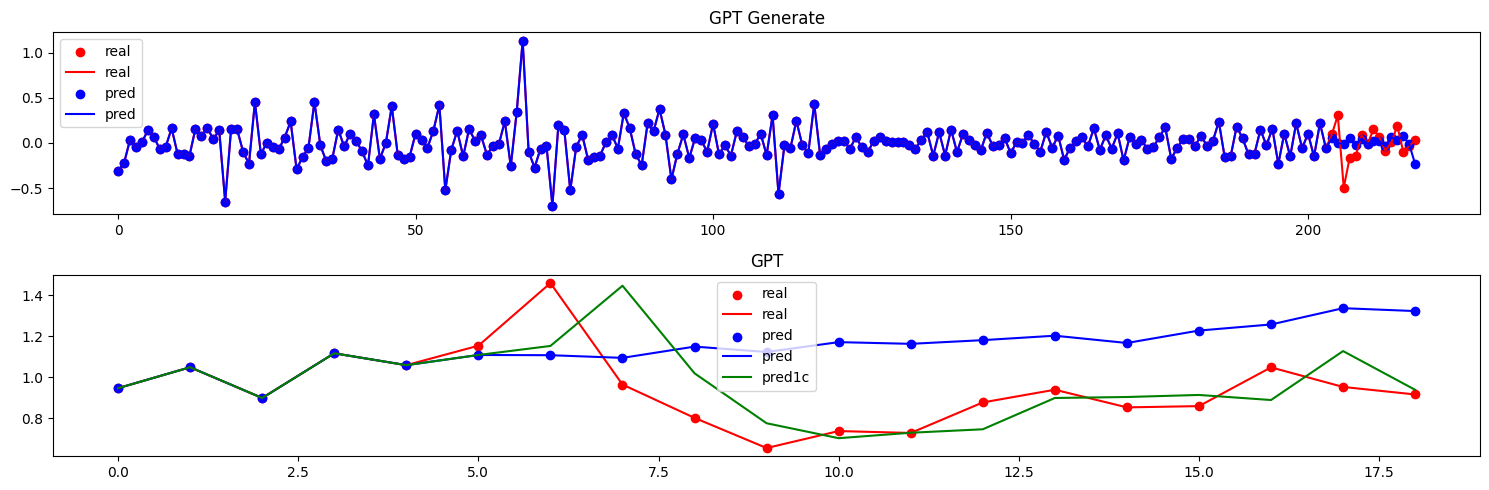

In [87]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.3857389688491821
500 train loss =  0.04717758297920227
1000 train loss =  0.020545532926917076
1500 train loss =  0.014235083013772964
2000 train loss =  0.008434250950813293
2500 train loss =  0.006092395167797804


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


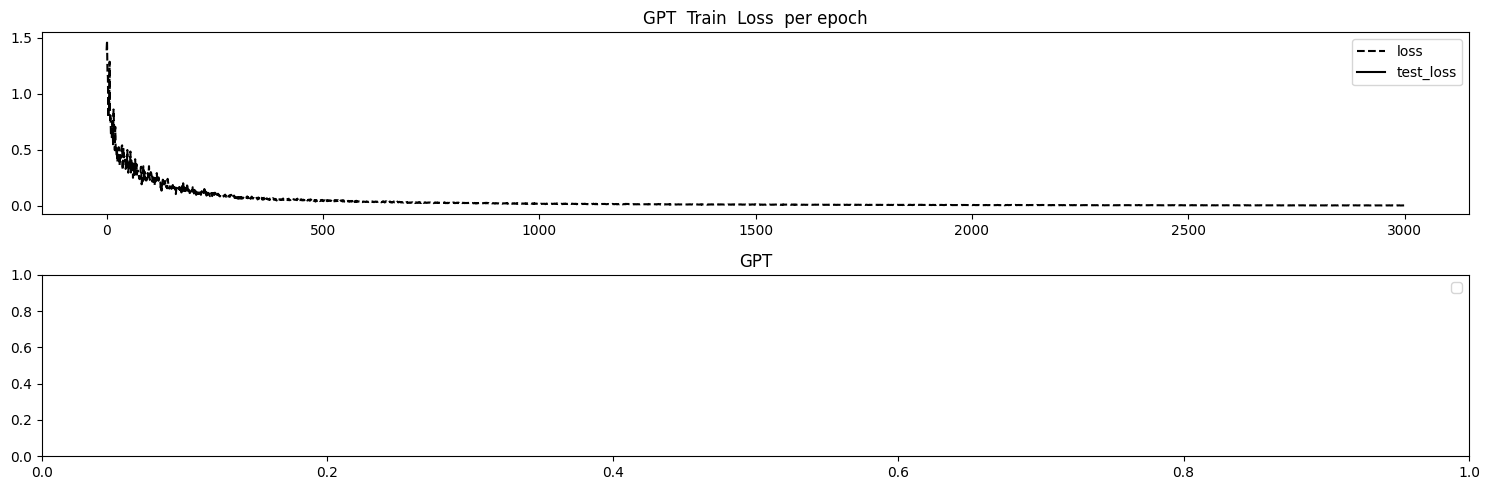

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04630260914564133
Test MSE Loss - SI only 0-5:  0.09707025438547134
Test MSE Loss - SI only 5-10:  0.0766553059220314
Test MSE Loss - SI only 10-15:  0.009420337155461311
mae, mse, rmse, mape, mspe, rse, corr
(0.17597519, 0.046302605, 0.2151804, 2.2425508, 11.65091, 1.243863)
Testing R**2 - SI only:  -0.5471952065972701
Testing R**2 - SI only:  -0.5471952065972701
Testing R**2 - All features:  0.9731912542289551


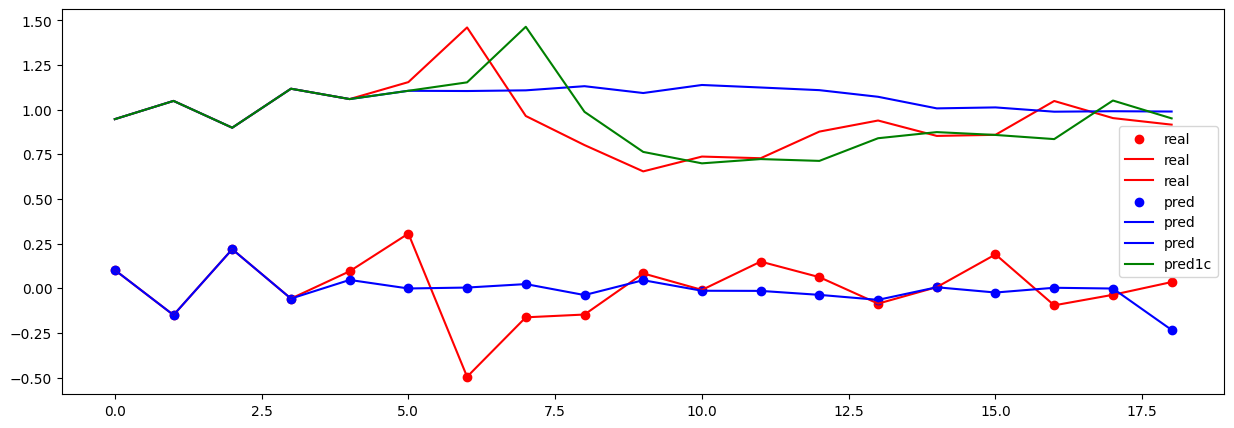

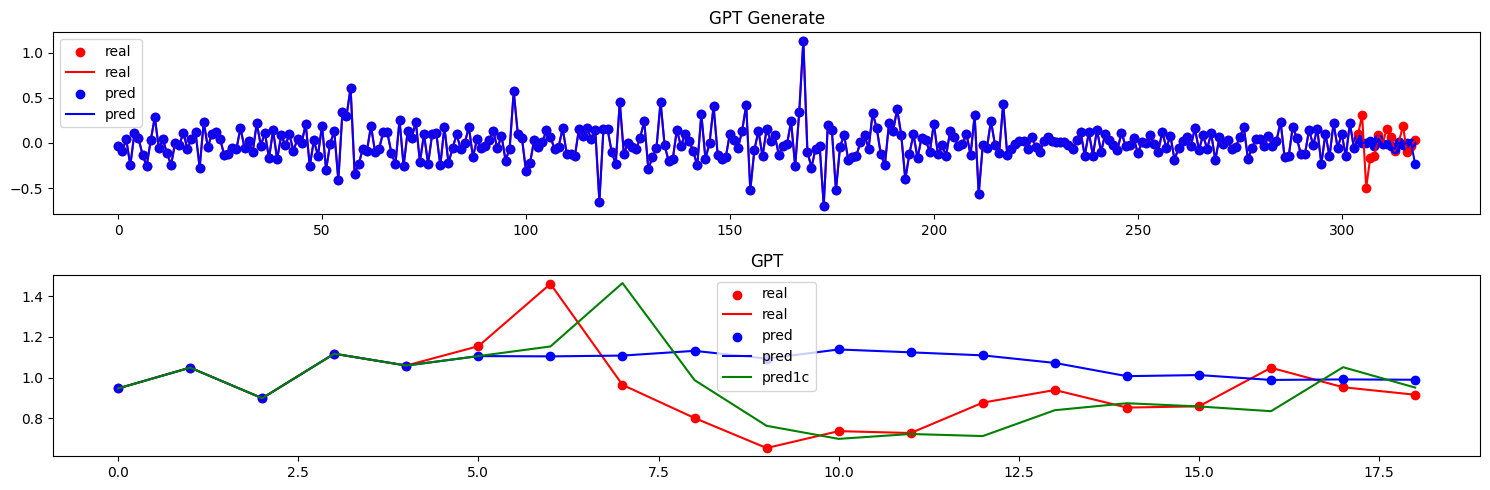

In [88]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.0091899633407593
500 train loss =  0.05822485312819481
1000 train loss =  0.021868092939257622
1500 train loss =  0.01363362092524767
2000 train loss =  0.008463031612336636
2500 train loss =  0.007387859281152487


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


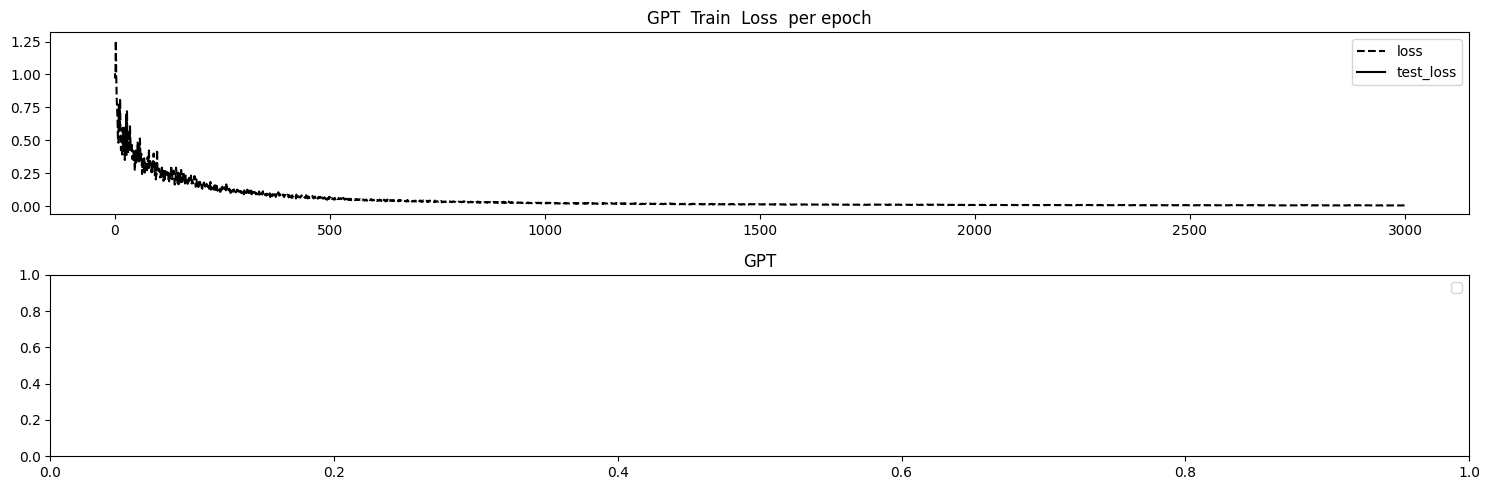

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.050951581448316574
Test MSE Loss - SI only 0-5:  0.09707023948431015
Test MSE Loss - SI only 5-10:  0.09565474838018417
Test MSE Loss - SI only 10-15:  0.00867958553135395
mae, mse, rmse, mape, mspe, rse, corr
(0.18047565, 0.050951578, 0.22572456, 1.9343009, 6.0957146, 1.3048141)
Testing R**2 - SI only:  -0.7025399451965901
Testing R**2 - SI only:  -0.7025399451965901
Testing R**2 - All features:  0.9951959785008943


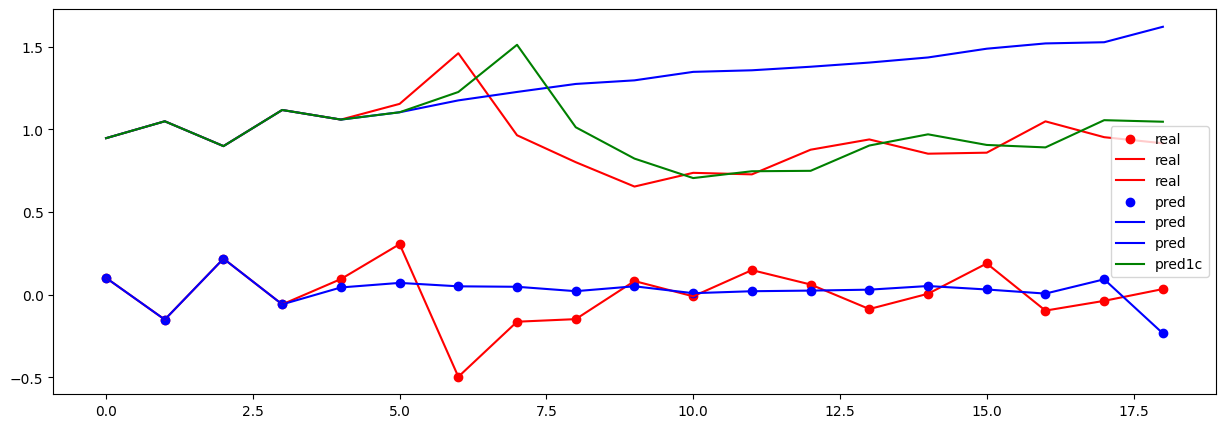

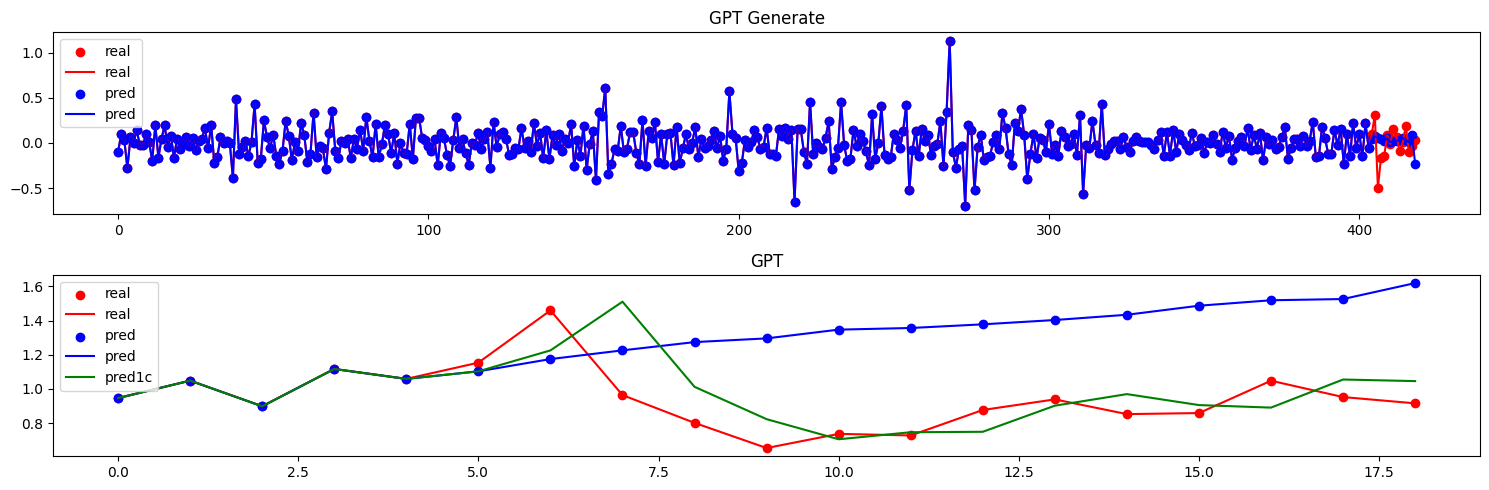

In [89]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 2


In [90]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





1383
447
862
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.2406734228134155
500 train loss =  0.022277384996414185
1000 train loss =  0.01020857598632574
1500 train loss =  0.006214079912751913
2000 train loss =  0.004552405793219805
2500 train loss =  0.003626385238021612


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


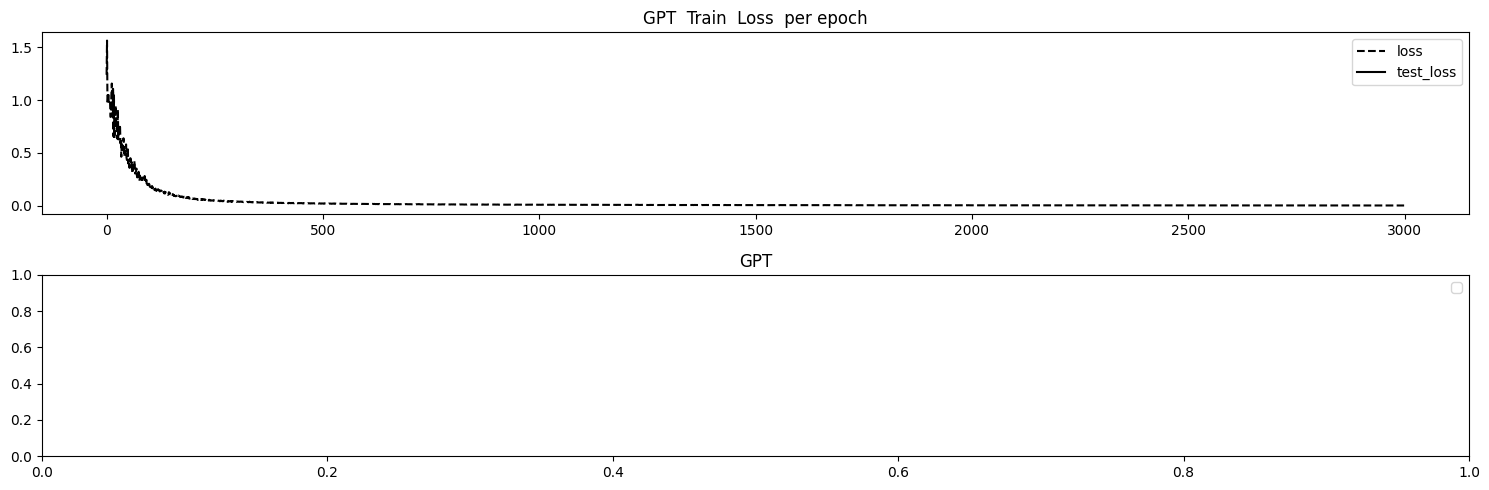

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03759343549609184
Test MSE Loss - SI only 0-5:  0.10699083656072617
Test MSE Loss - SI only 5-10:  0.012966054491698742
Test MSE Loss - SI only 10-15:  0.015886837616562843
mae, mse, rmse, mape, mspe, rse, corr
(0.15129697, 0.037593435, 0.19389027, 1.7120371, 4.9680076, 1.5071076)
Testing R**2 - SI only:  -1.2713733200224828
Testing R**2 - SI only:  -1.2713733200224828
Testing R**2 - All features:  0.9934951523733748


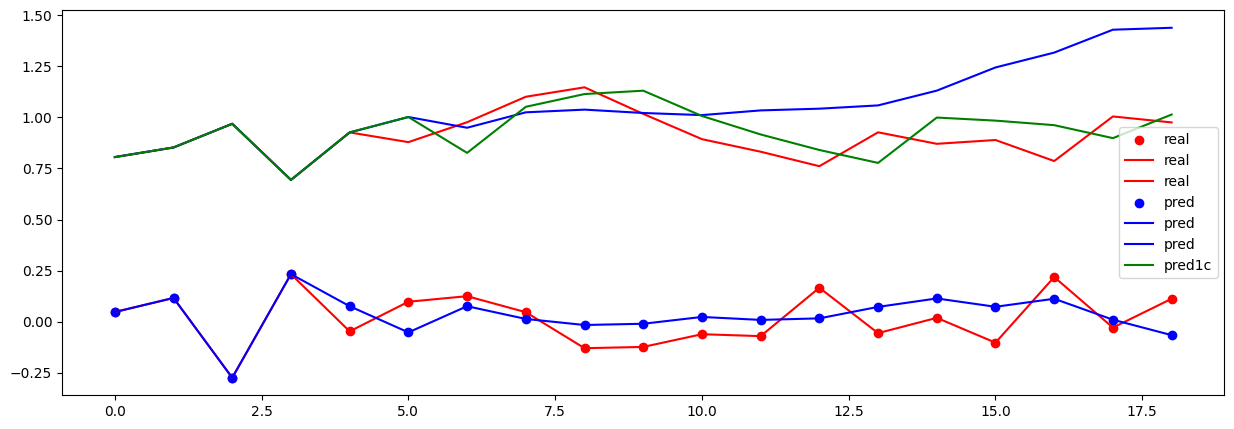

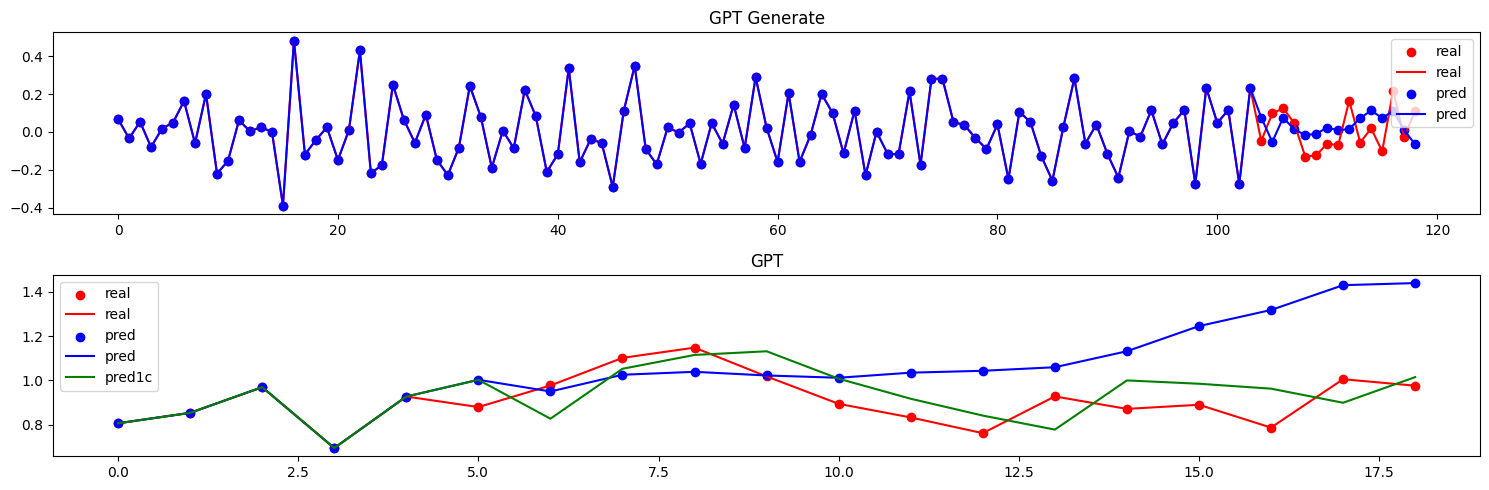

In [91]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([200, 25])
0 train loss =  0.9695615768432617
500 train loss =  0.040097322314977646
1000 train loss =  0.016229812055826187
1500 train loss =  0.00919396709650755
2000 train loss =  0.007158184424042702
2500 train loss =  0.0051838308572769165


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


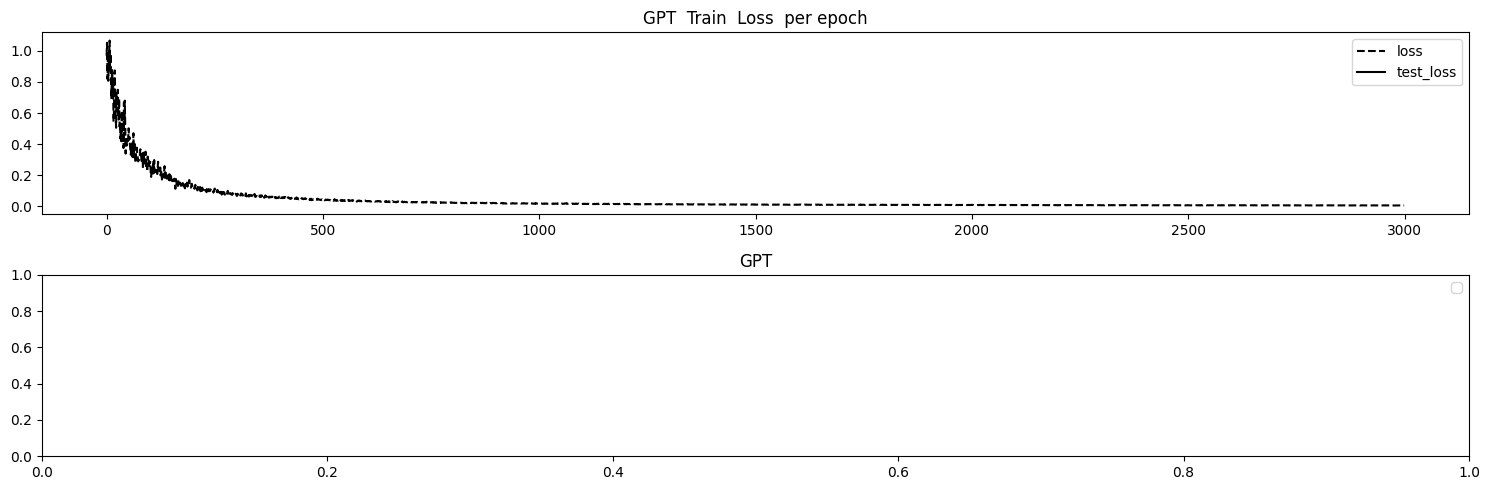

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.034677326679229736
Test MSE Loss - SI only 0-5:  0.10699082911014557
Test MSE Loss - SI only 5-10:  0.009113459847867489
Test MSE Loss - SI only 10-15:  0.011870939284563065
mae, mse, rmse, mape, mspe, rse, corr
(0.13285984, 0.034677323, 0.18621849, 1.3686686, 3.6937413, 1.447475)
Testing R**2 - SI only:  -1.0951835495440467
Testing R**2 - SI only:  -1.0951835495440467
Testing R**2 - All features:  0.9923175802132405


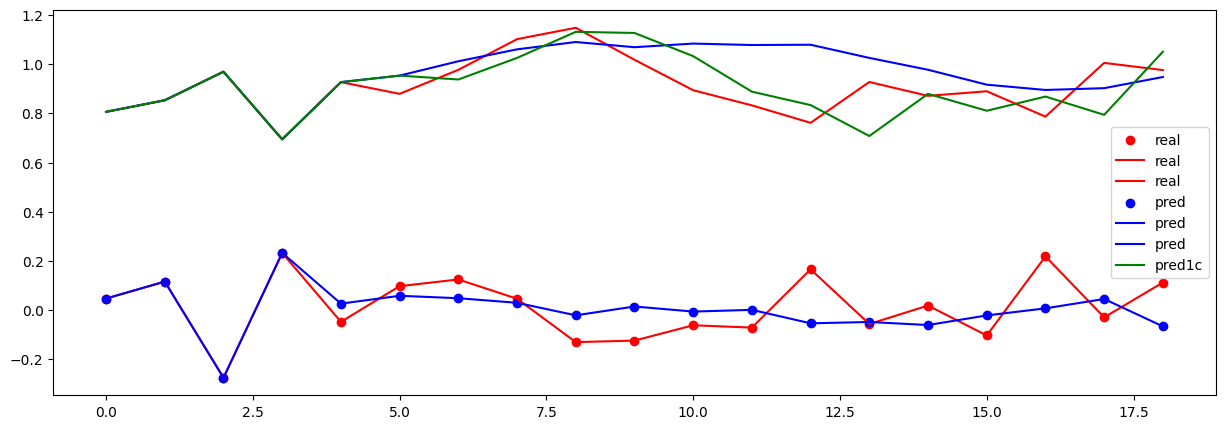

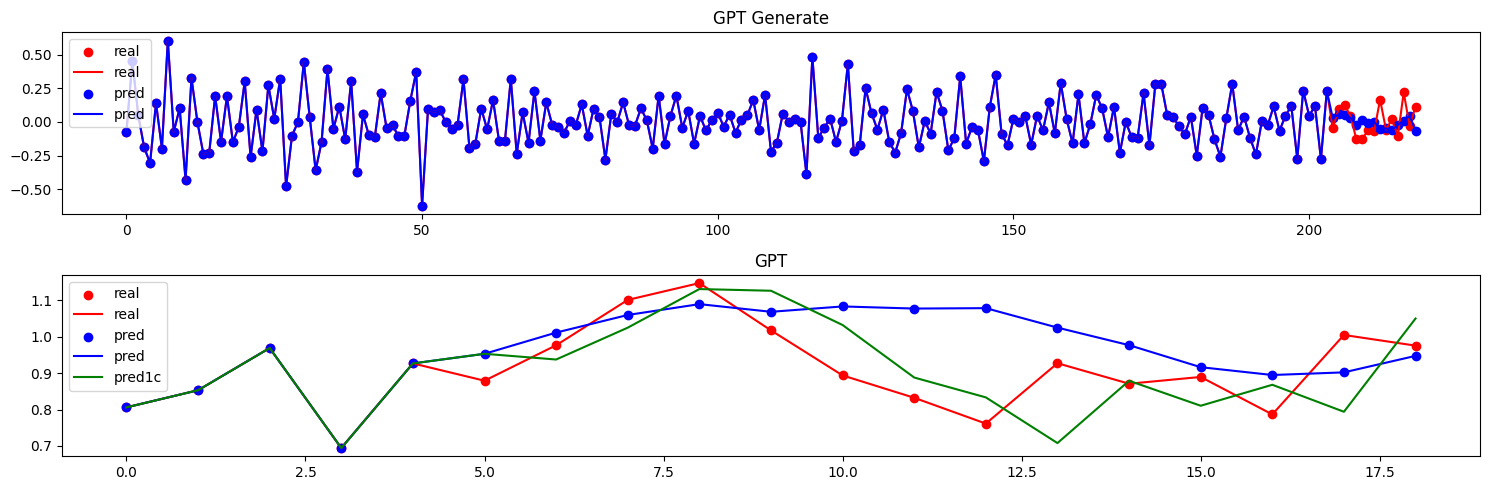

In [92]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([300, 25])
0 train loss =  0.9690372347831726
500 train loss =  0.050688181072473526
1000 train loss =  0.019179150462150574
1500 train loss =  0.015447553247213364
2000 train loss =  0.007975219748914242
2500 train loss =  0.0062932660803198814


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


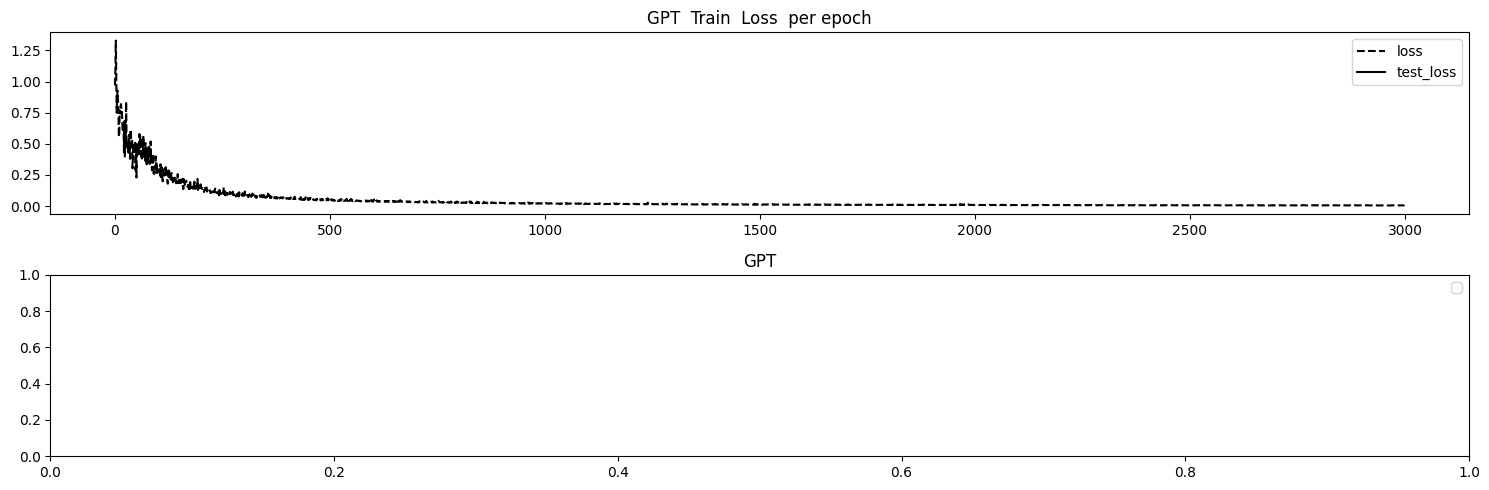

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.0356295183300972
Test MSE Loss - SI only 0-5:  0.10699082911014557
Test MSE Loss - SI only 5-10:  0.017222777009010315
Test MSE Loss - SI only 10-15:  0.009375949390232563
mae, mse, rmse, mape, mspe, rse, corr
(0.13445842, 0.03562952, 0.18875784, 1.3156807, 3.2978117, 1.4672133)
Testing R**2 - SI only:  -1.1527145897685243
Testing R**2 - SI only:  -1.1527145897685243
Testing R**2 - All features:  0.9959187011453261


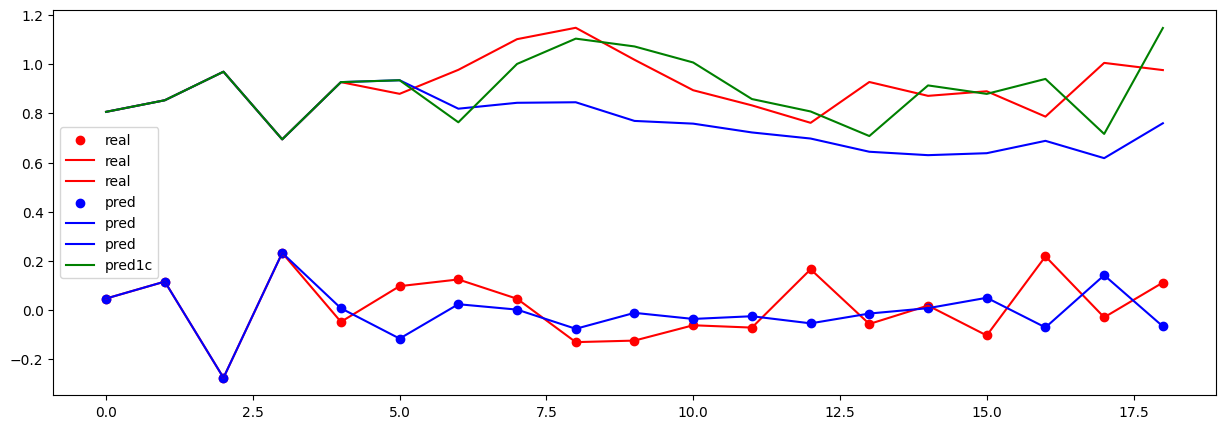

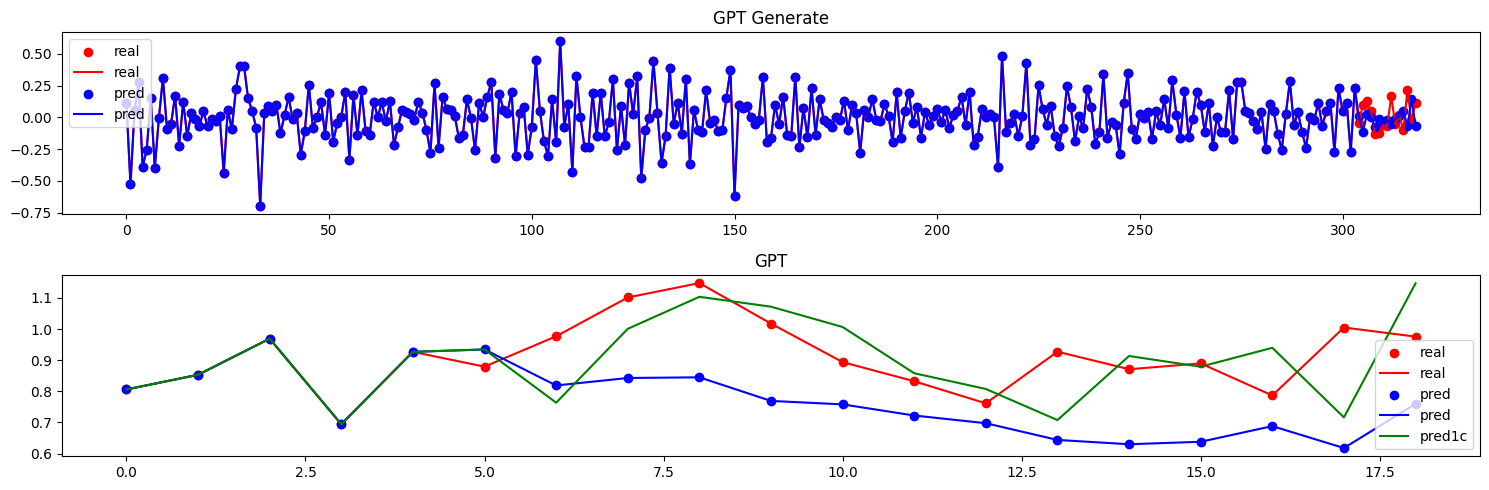

In [93]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.262040376663208
500 train loss =  0.054237548261880875
1000 train loss =  0.02534019947052002
1500 train loss =  0.013376375660300255
2000 train loss =  0.01036179717630148
2500 train loss =  0.007187147159129381


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


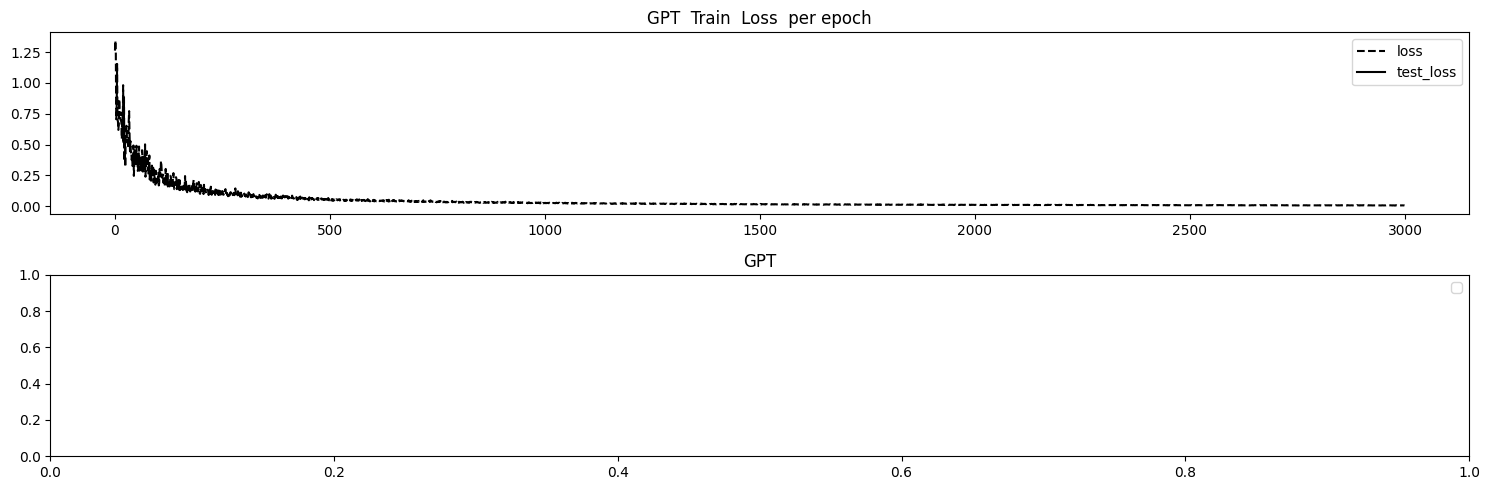

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03546133264899254
Test MSE Loss - SI only 0-5:  0.10699082911014557
Test MSE Loss - SI only 5-10:  0.011299602687358856
Test MSE Loss - SI only 10-15:  0.012311536818742752
mae, mse, rmse, mape, mspe, rse, corr
(0.13565762, 0.03546133, 0.18831179, 1.2456021, 3.118612, 1.4637461)
Testing R**2 - SI only:  -1.1425527931823405
Testing R**2 - SI only:  -1.1425527931823405
Testing R**2 - All features:  0.9980732646884602


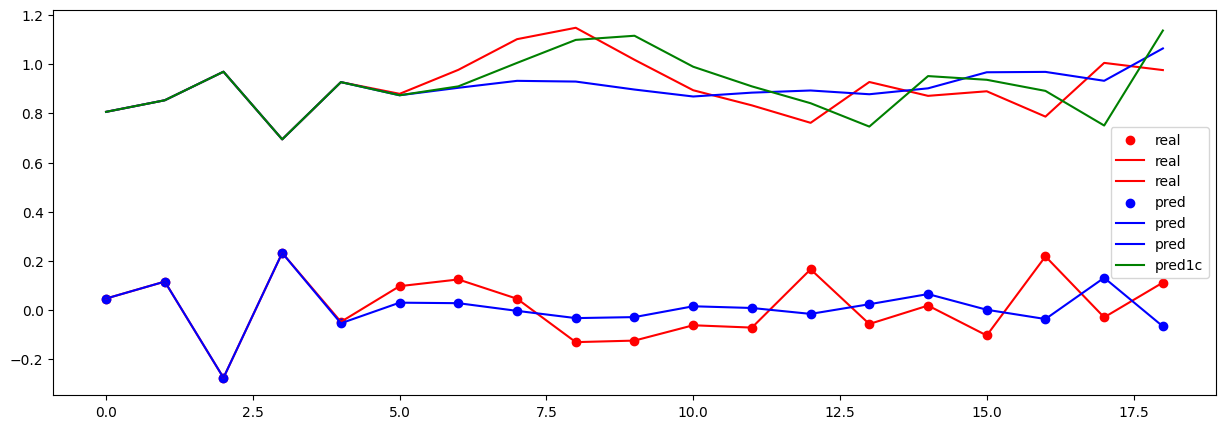

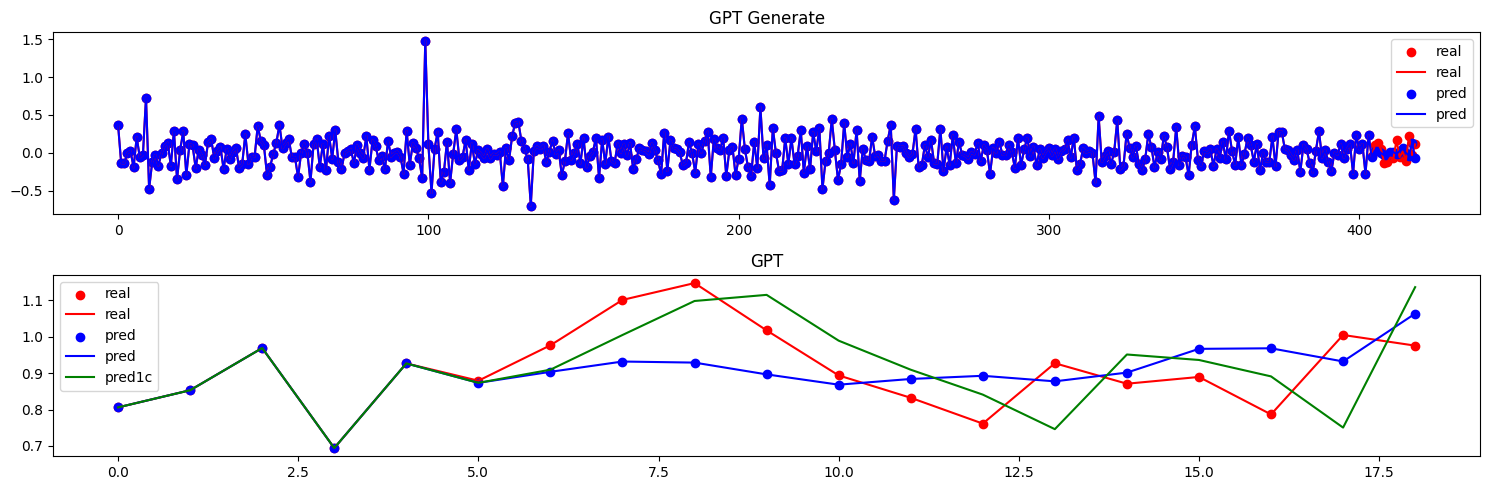

In [94]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 3


In [95]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



1383
458
873
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.458309531211853
500 train loss =  0.024597086012363434
1000 train loss =  0.011302554048597813
1500 train loss =  0.0069998474791646
2000 train loss =  0.004970515612512827
2500 train loss =  0.004101476166397333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


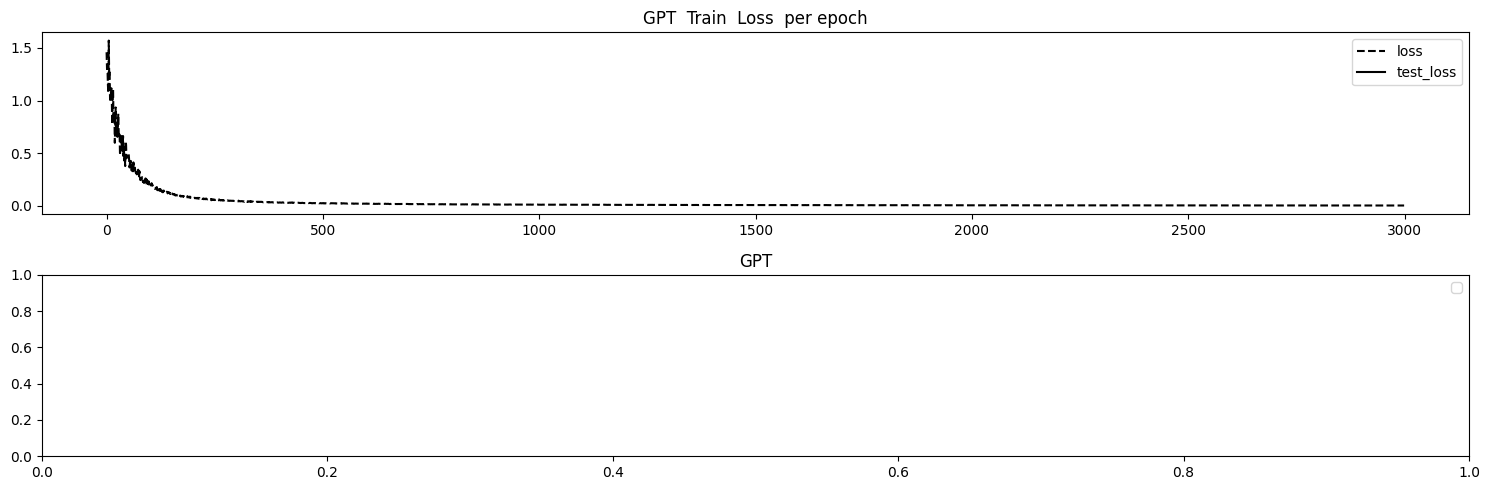

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.02726210094988346
Test MSE Loss - SI only 0-5:  0.02780170924961567
Test MSE Loss - SI only 5-10:  0.021262798458337784
Test MSE Loss - SI only 10-15:  0.03174174949526787
mae, mse, rmse, mape, mspe, rse, corr
(0.14361958, 0.027262101, 0.16511239, 33.155712, 19144.201, 1.2657244)
Testing R**2 - SI only:  -0.6020585084960928
Testing R**2 - SI only:  -0.6020585084960928
Testing R**2 - All features:  0.9958415036069844


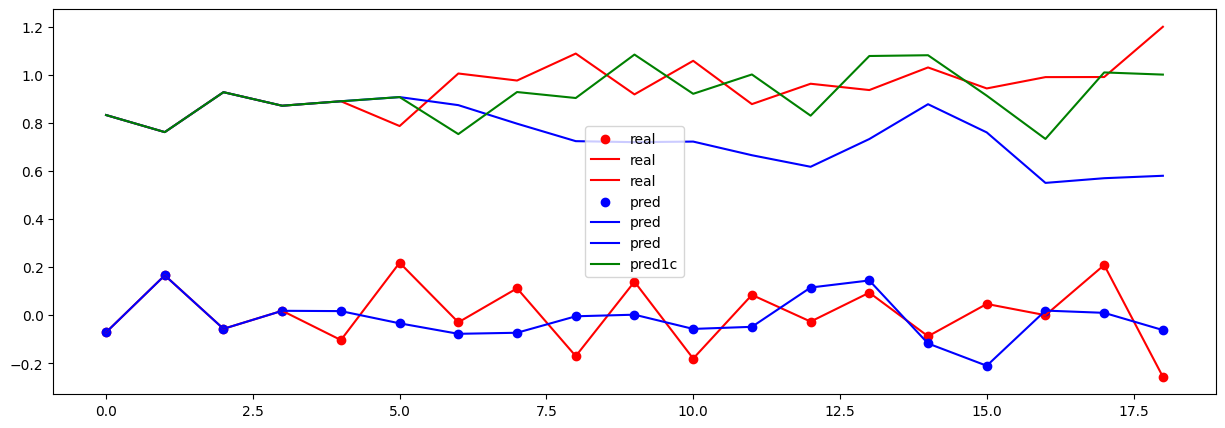

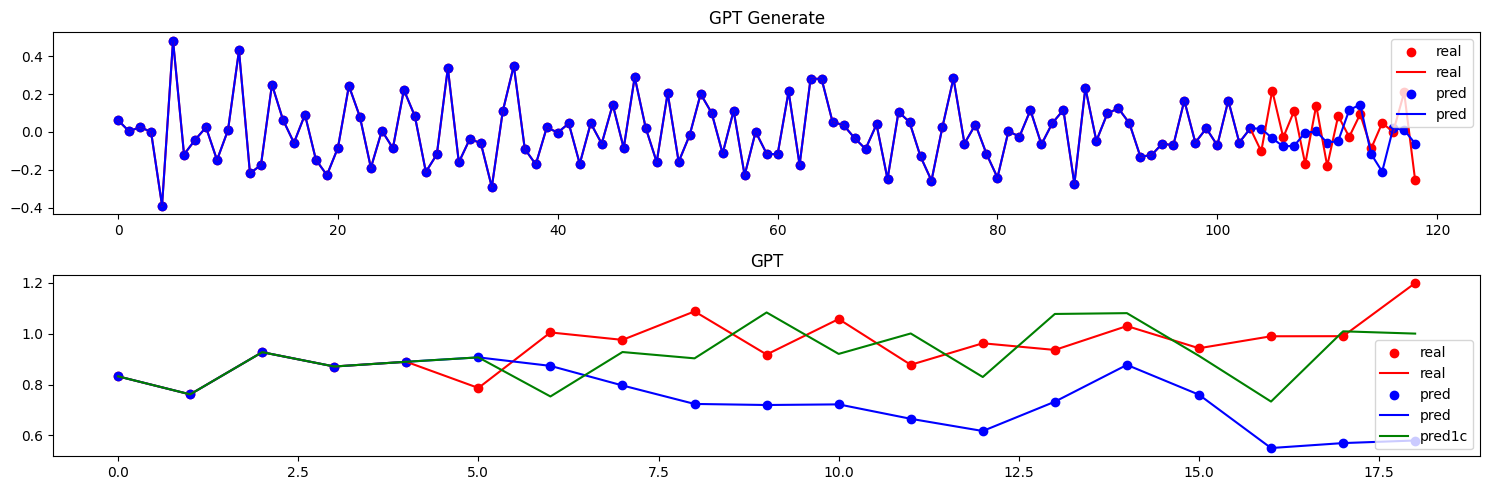

In [96]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.0794259309768677
500 train loss =  0.031245607882738113
1000 train loss =  0.013723301701247692
1500 train loss =  0.008294018916785717
2000 train loss =  0.006713203154504299
2500 train loss =  0.005013629328459501


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


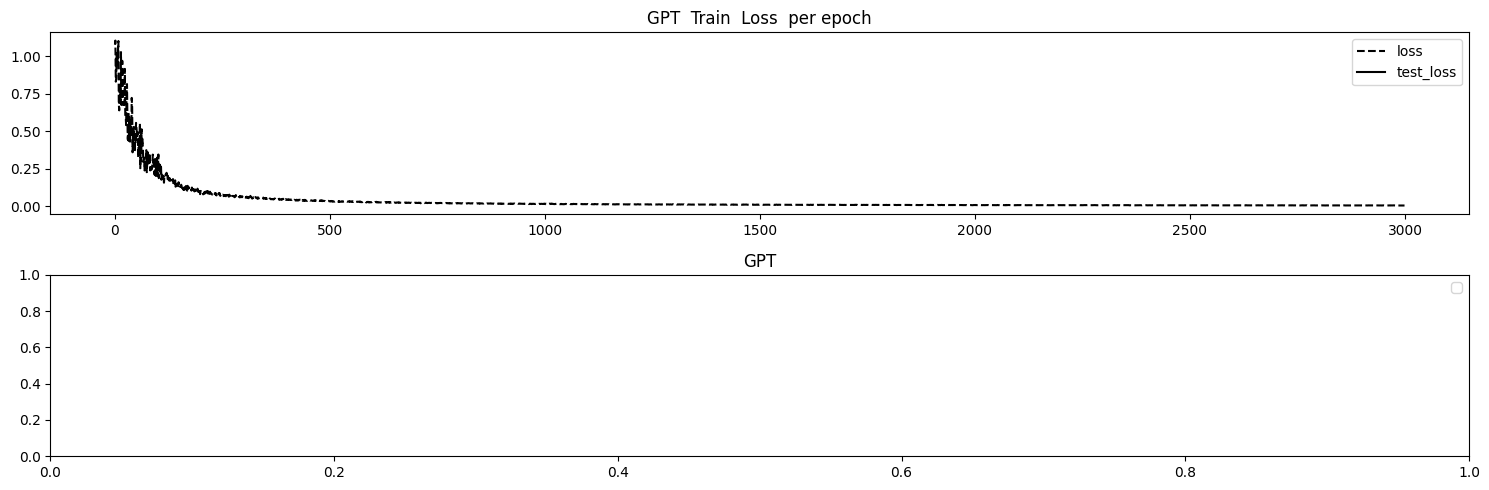

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.018929148092865944
Test MSE Loss - SI only 0-5:  0.02780170552432537
Test MSE Loss - SI only 5-10:  0.021681247279047966
Test MSE Loss - SI only 10-15:  0.01391749456524849
mae, mse, rmse, mape, mspe, rse, corr
(0.11626989, 0.018929148, 0.13758324, 11.889676, 2186.6387, 1.0546906)
Testing R**2 - SI only:  -0.1123723030643311
Testing R**2 - SI only:  -0.1123723030643311
Testing R**2 - All features:  0.9940165935039001


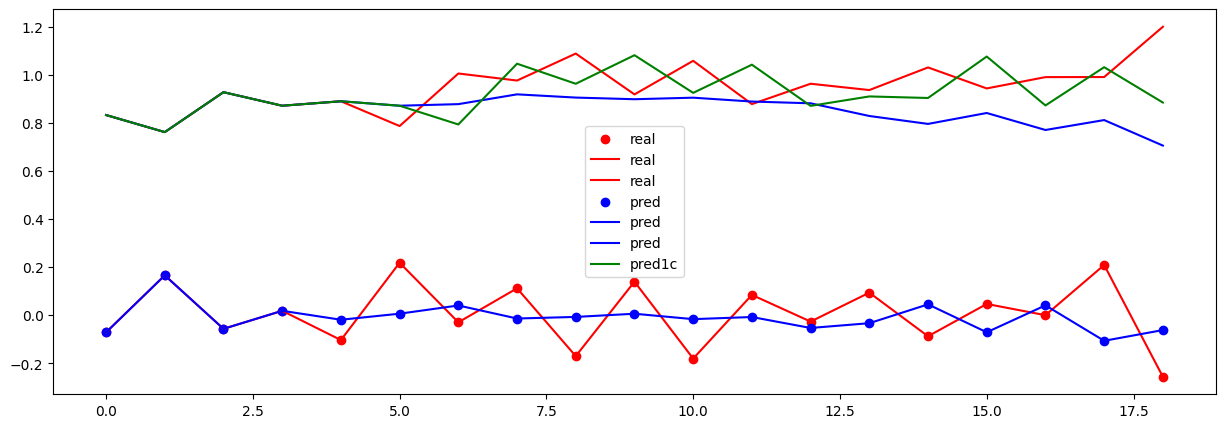

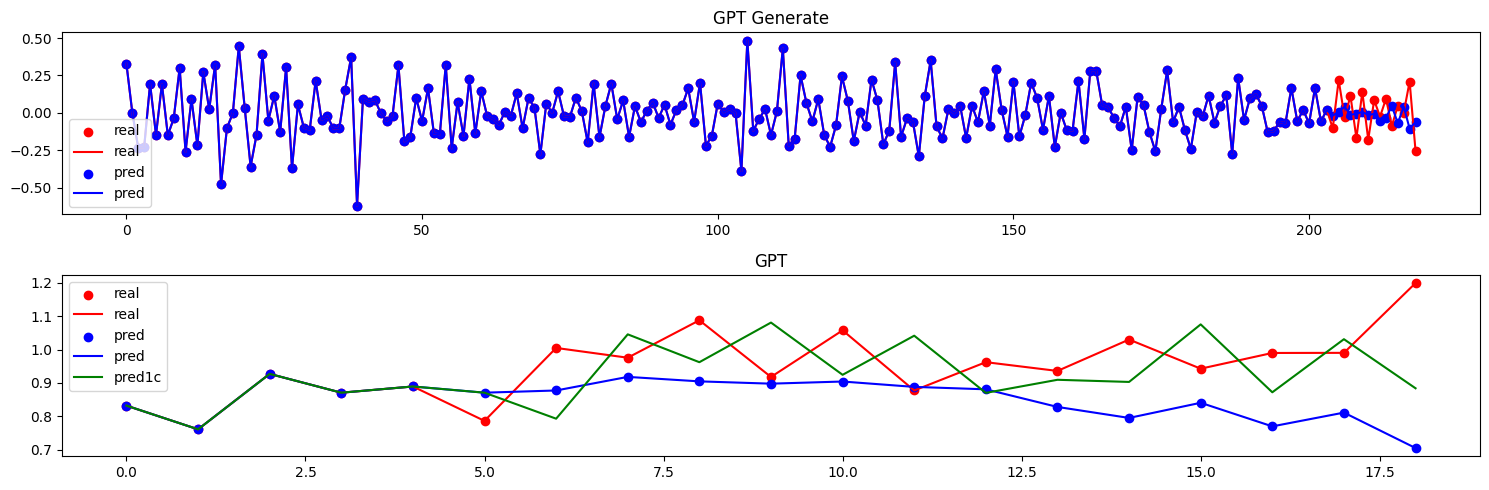

In [97]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([300, 25])
0 train loss =  1.2219550609588623
500 train loss =  0.058059487491846085
1000 train loss =  0.02122860588133335
1500 train loss =  0.012962008826434612
2000 train loss =  0.008904054760932922
2500 train loss =  0.006978721357882023


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


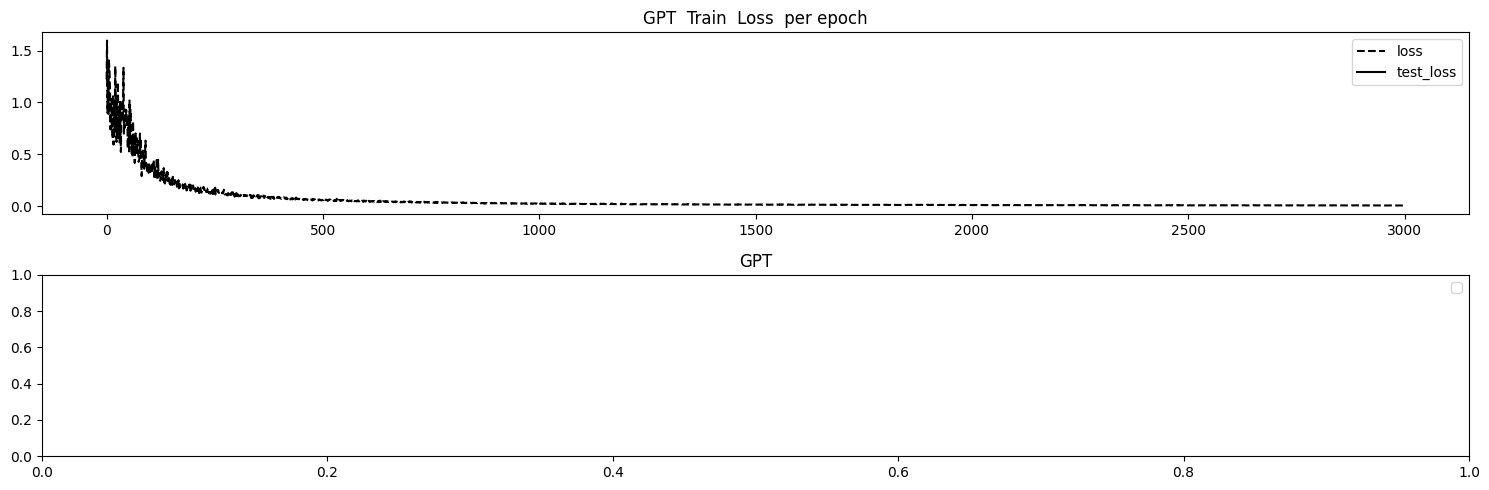

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.02255975641310215
Test MSE Loss - SI only 0-5:  0.02780170552432537
Test MSE Loss - SI only 5-10:  0.016122162342071533
Test MSE Loss - SI only 10-15:  0.024670489132404327
mae, mse, rmse, mape, mspe, rse, corr
(0.12895218, 0.022559756, 0.15019906, 22.472805, 8462.861, 1.1514013)
Testing R**2 - SI only:  -0.3257250729395267
Testing R**2 - SI only:  -0.3257250729395267
Testing R**2 - All features:  0.9934262524679959


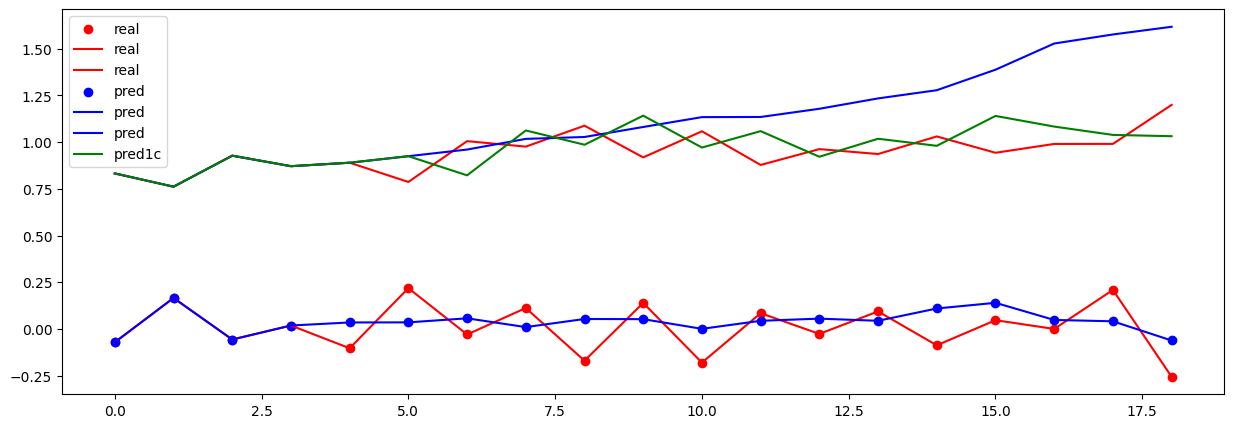

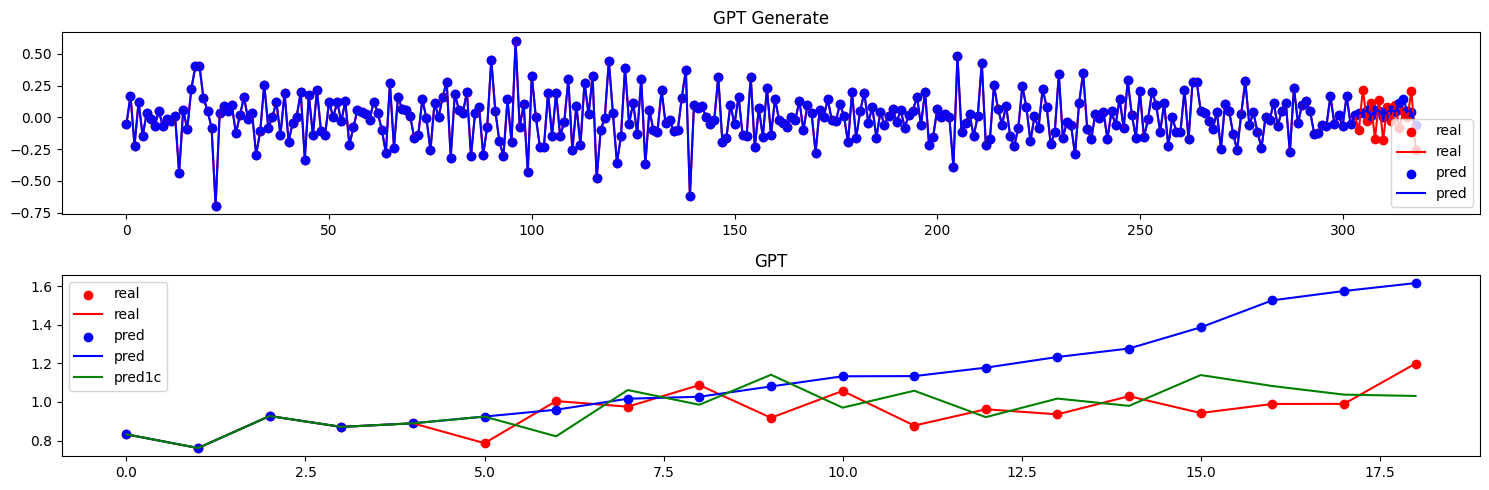

In [98]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string  = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.2017425298690796
500 train loss =  0.058440715074539185
1000 train loss =  0.023768898099660873
1500 train loss =  0.014478864148259163
2000 train loss =  0.010925589129328728
2500 train loss =  0.006568691227585077


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


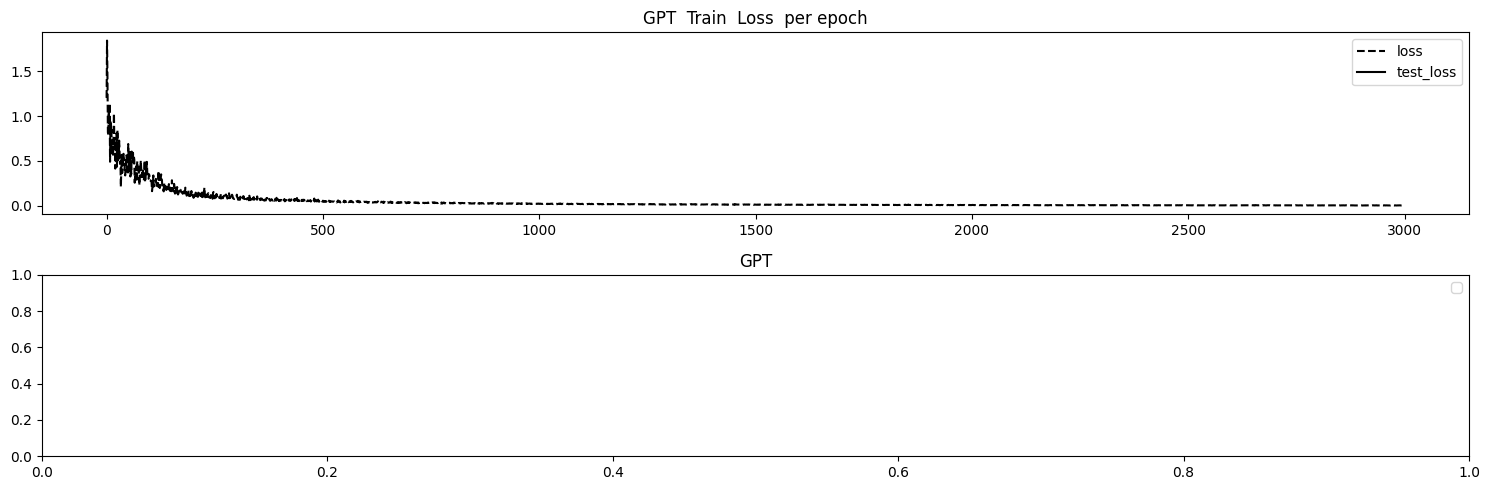

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.021727167069911957
Test MSE Loss - SI only 0-5:  0.02780170552432537
Test MSE Loss - SI only 5-10:  0.019235899671912193
Test MSE Loss - SI only 10-15:  0.021182941272854805
mae, mse, rmse, mape, mspe, rse, corr
(0.12633401, 0.021727163, 0.14740136, 4.9924965, 251.0448, 1.1299547)
Testing R**2 - SI only:  -0.2767978134713265
Testing R**2 - SI only:  -0.2767978134713265
Testing R**2 - All features:  0.9984647421016787


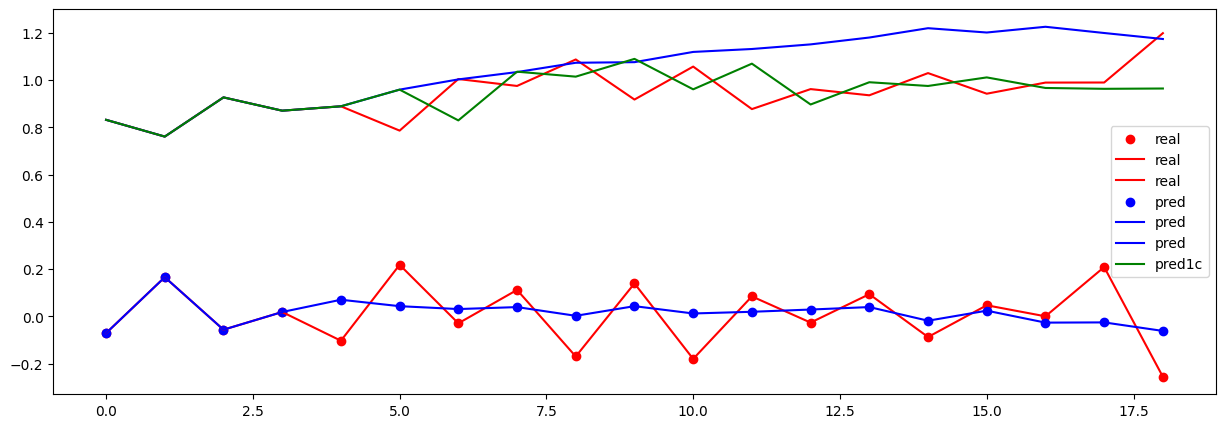

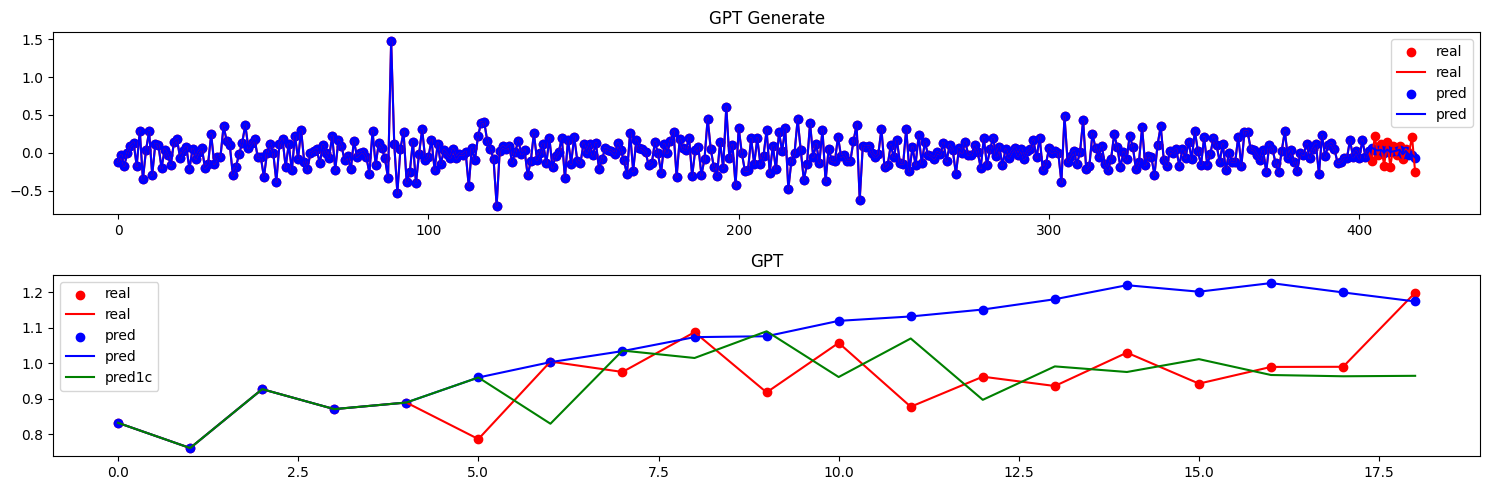

In [99]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 4


In [100]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
10
425
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.2641890048980713
500 train loss =  0.019320674240589142
1000 train loss =  0.008993900381028652
1500 train loss =  0.005300668068230152
2000 train loss =  0.004314215388149023
2500 train loss =  0.0030995539855211973


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


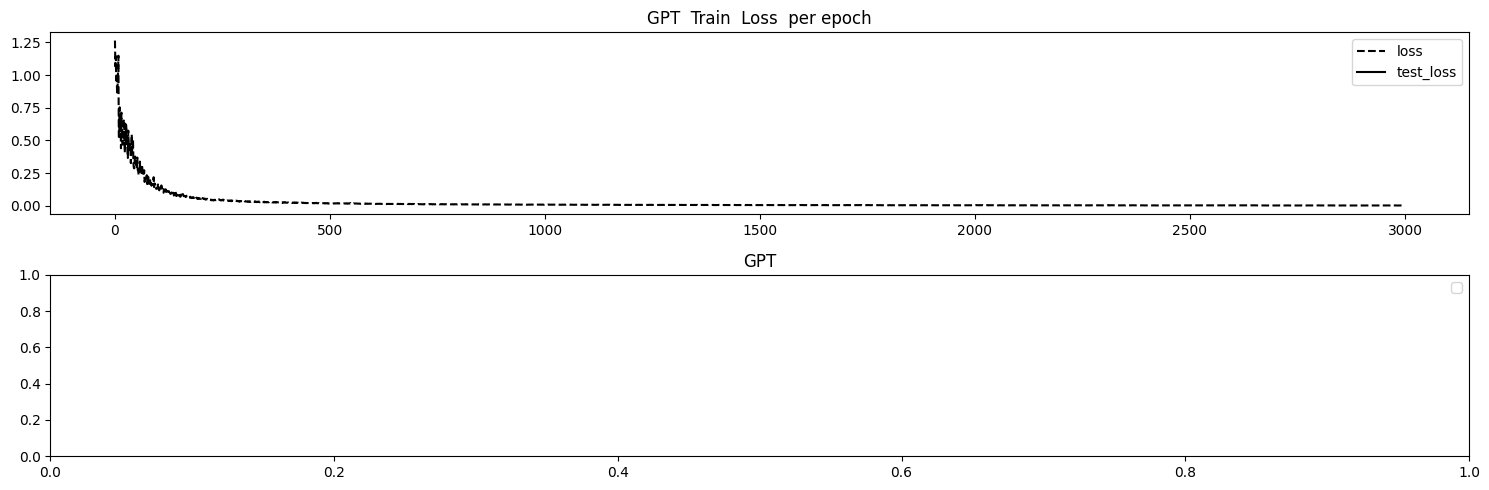

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04559405520558357
Test MSE Loss - SI only 0-5:  0.09381111711263657
Test MSE Loss - SI only 5-10:  0.0032455127220600843
Test MSE Loss - SI only 10-15:  0.020057164132595062
mae, mse, rmse, mape, mspe, rse, corr
(0.15119421, 0.04559406, 0.21352765, 14.633527, 3425.5828, 1.4572402)
Testing R**2 - SI only:  -1.123548551002794
Testing R**2 - SI only:  -1.123548551002794
Testing R**2 - All features:  0.9631150903993452


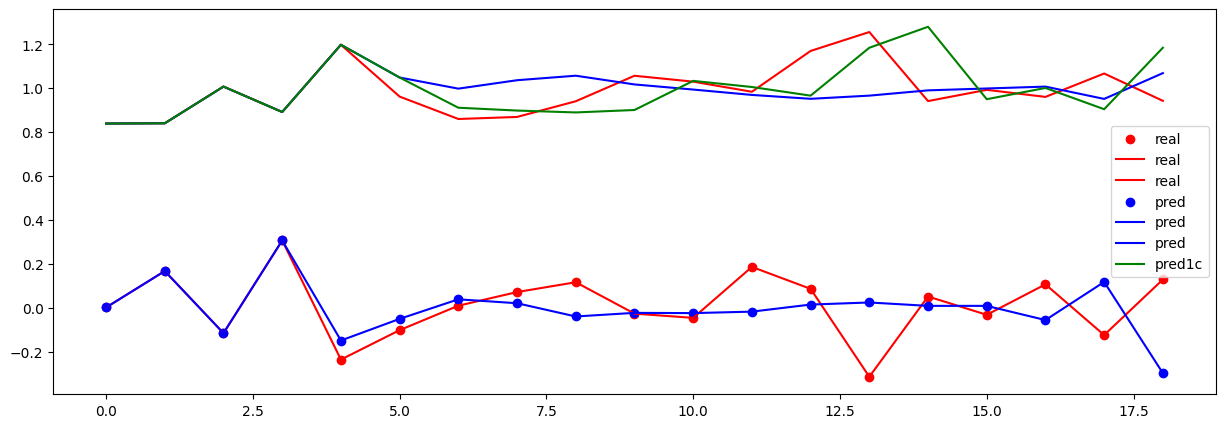

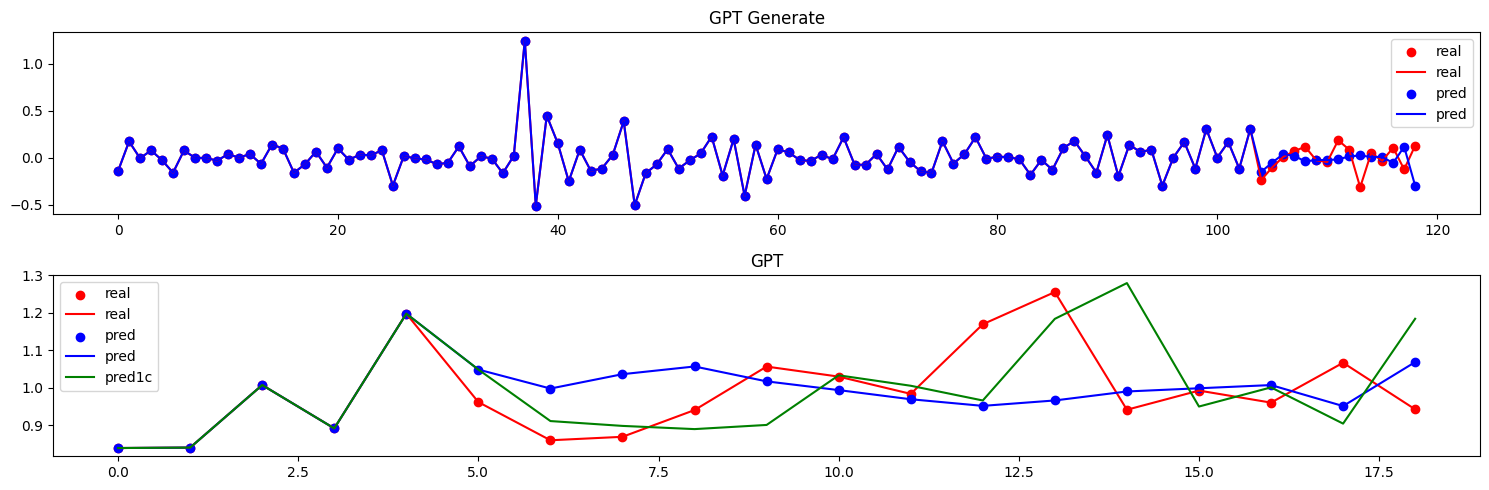

In [101]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.7056266069412231
500 train loss =  0.03707320988178253
1000 train loss =  0.017642296850681305
1500 train loss =  0.00877122301608324
2000 train loss =  0.006767408922314644
2500 train loss =  0.004724237602204084


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


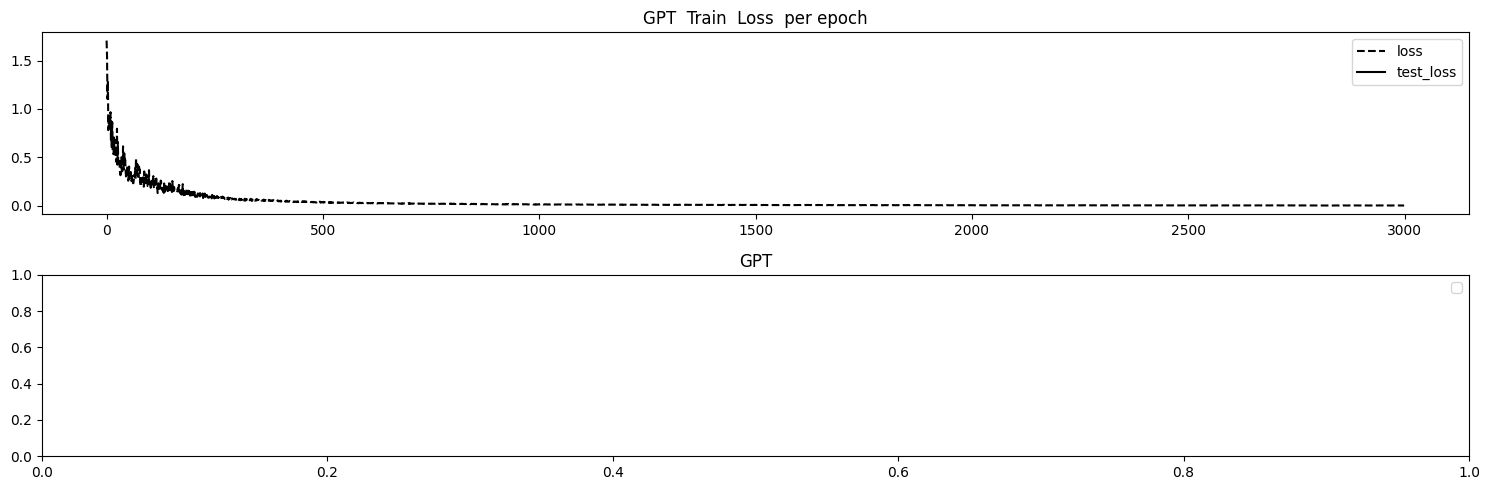

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.050268691033124924
Test MSE Loss - SI only 0-5:  0.09381111711263657
Test MSE Loss - SI only 5-10:  0.010389753617346287
Test MSE Loss - SI only 10-15:  0.025956813246011734
mae, mse, rmse, mape, mspe, rse, corr
(0.1820925, 0.050268687, 0.22420679, 15.45281, 3434.1924, 1.530121)
Testing R**2 - SI only:  -1.3412701087922492
Testing R**2 - SI only:  -1.3412701087922492
Testing R**2 - All features:  0.9717991550339725


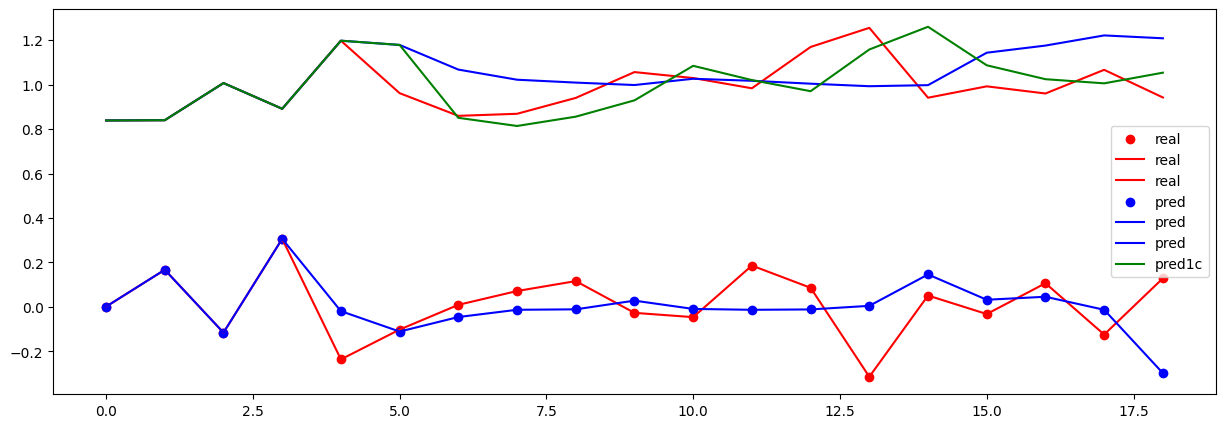

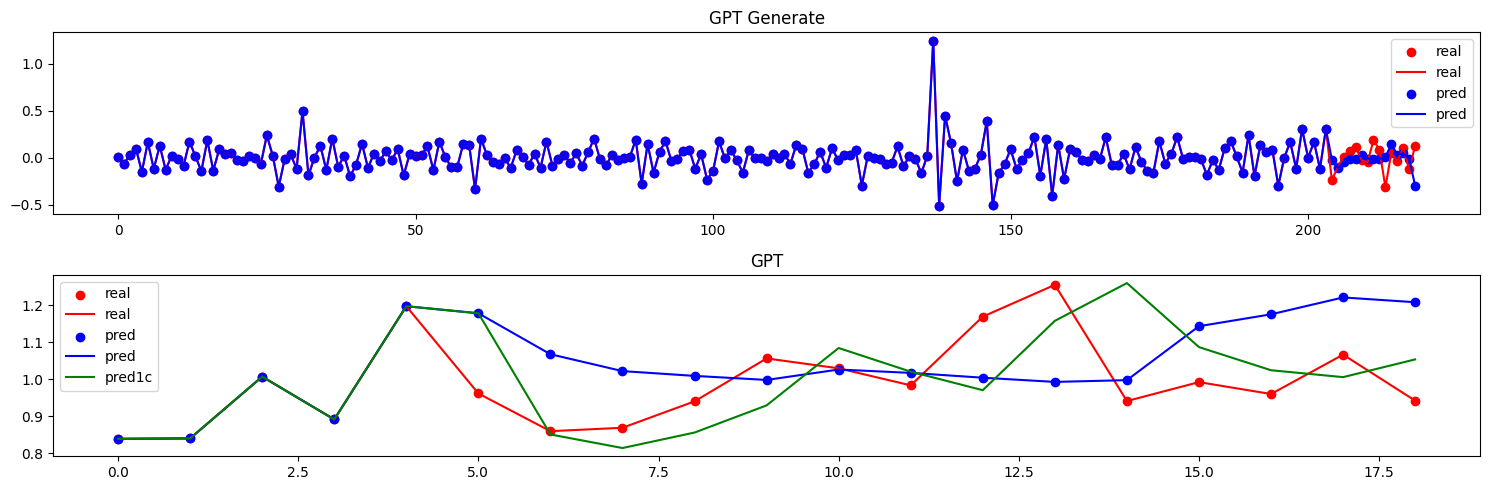

In [102]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.4615250825881958
500 train loss =  0.035537514835596085
1000 train loss =  0.01944952830672264
1500 train loss =  0.01063515618443489
2000 train loss =  0.00806153193116188
2500 train loss =  0.005382186733186245


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


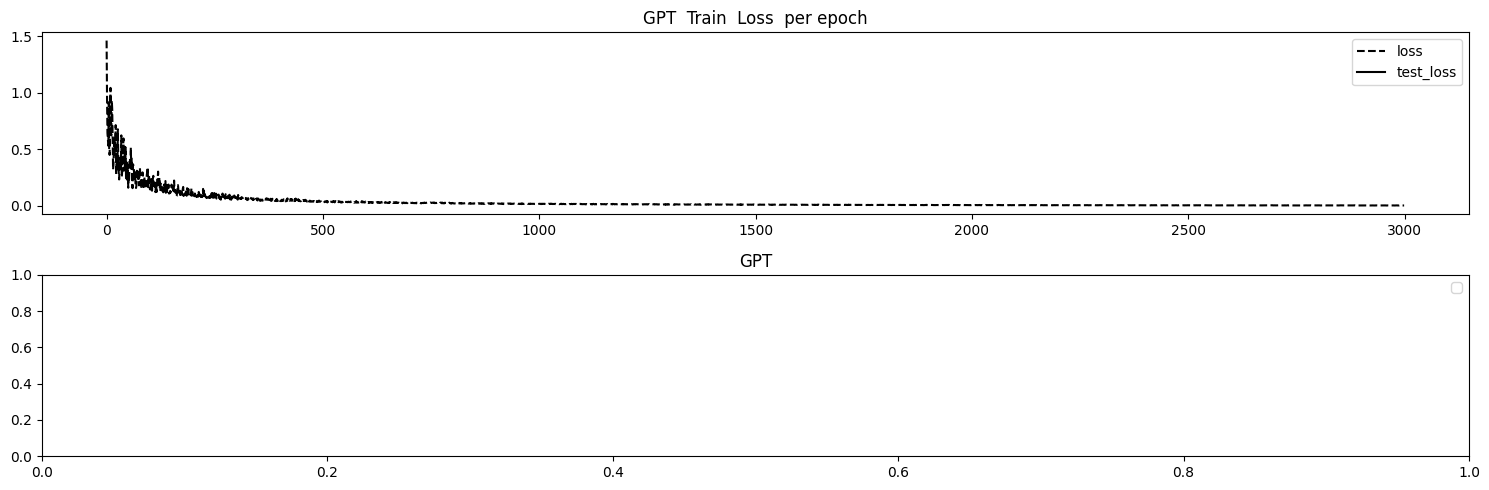

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04433334991335869
Test MSE Loss - SI only 0-5:  0.09381111711263657
Test MSE Loss - SI only 5-10:  0.0026933341287076473
Test MSE Loss - SI only 10-15:  0.01770245097577572
mae, mse, rmse, mape, mspe, rse, corr
(0.14737234, 0.04433335, 0.21055487, 14.361198, 3423.455, 1.4369521)
Testing R**2 - SI only:  -1.0648311838750488
Testing R**2 - SI only:  -1.0648311838750488
Testing R**2 - All features:  0.9522308087335748


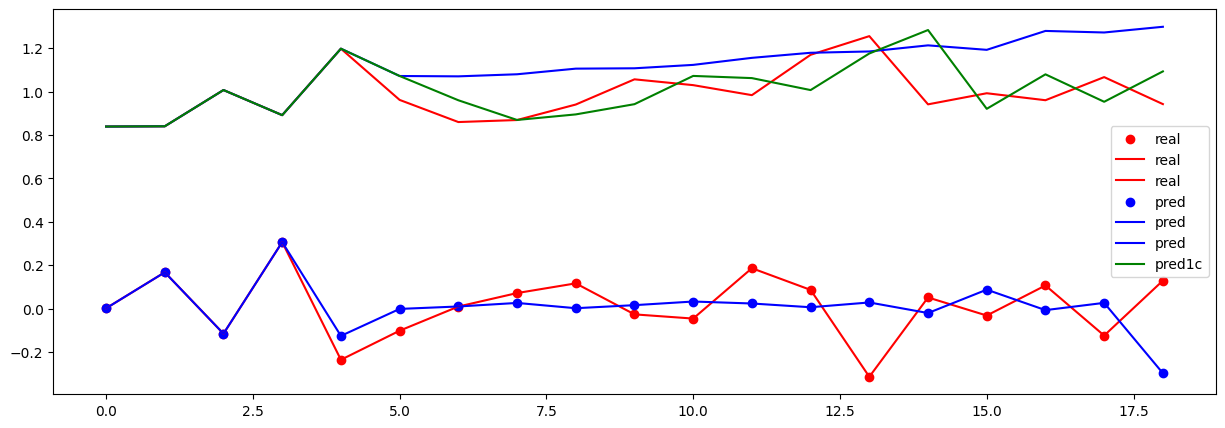

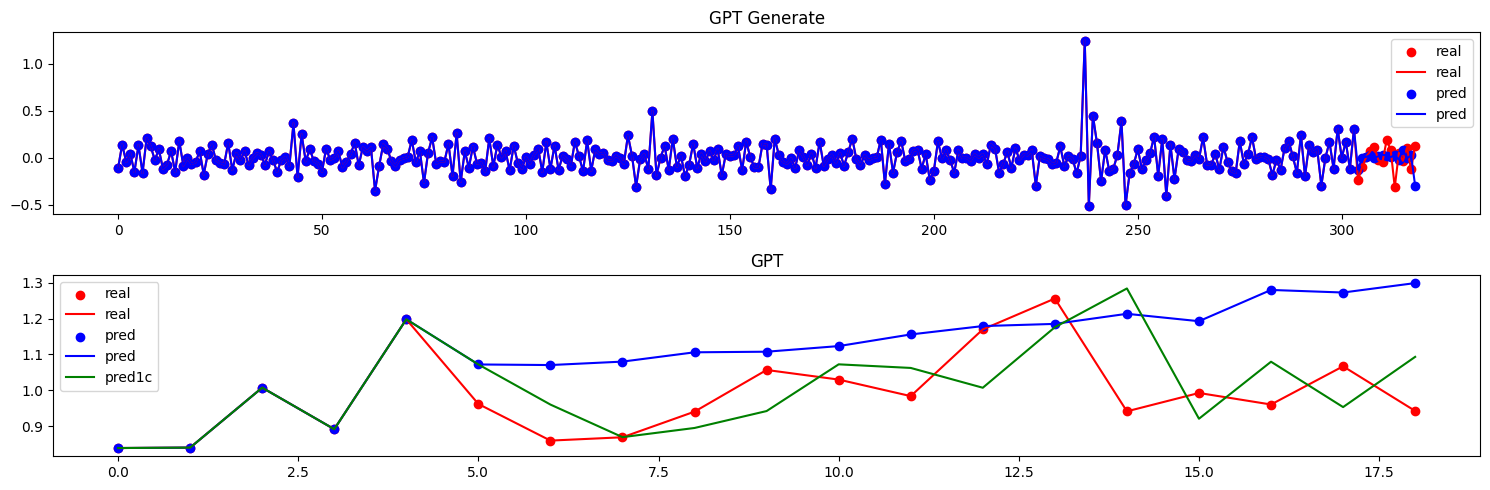

In [103]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([400, 25])
0 train loss =  1.0955300331115723
500 train loss =  0.05213433876633644
1000 train loss =  0.026959985494613647
1500 train loss =  0.016140330582857132
2000 train loss =  0.009233773685991764
2500 train loss =  0.007789470721036196


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


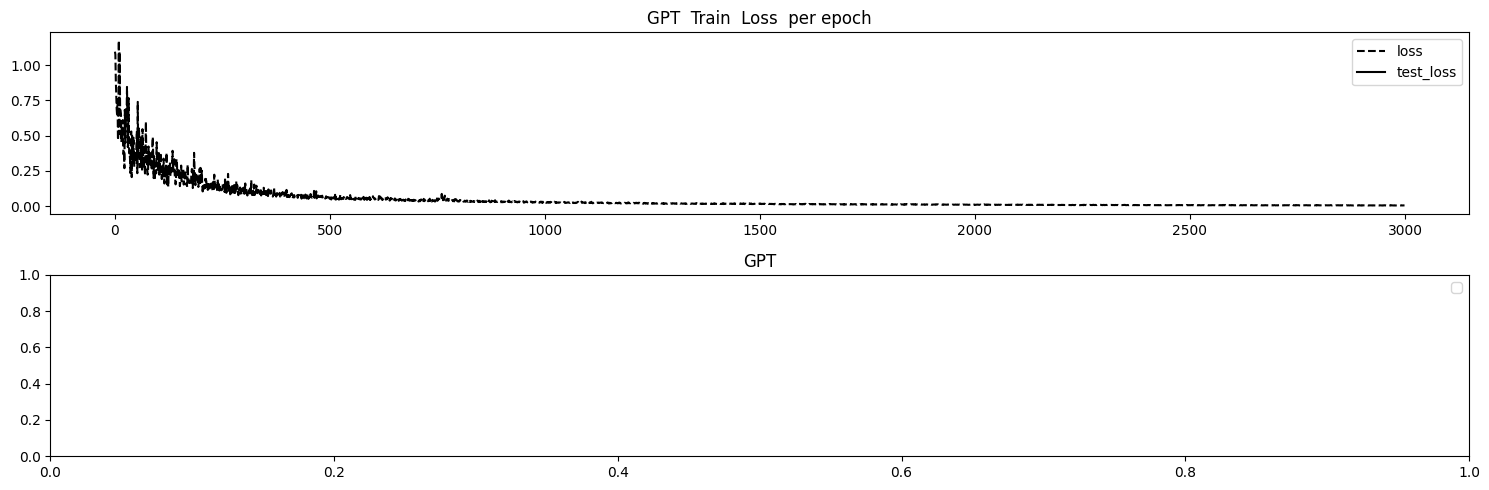

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04647567868232727
Test MSE Loss - SI only 0-5:  0.09381111711263657
Test MSE Loss - SI only 5-10:  0.003278904827311635
Test MSE Loss - SI only 10-15:  0.02189982868731022
mae, mse, rmse, mape, mspe, rse, corr
(0.16159055, 0.04647568, 0.21558219, 14.600051, 3424.1895, 1.4712615)
Testing R**2 - SI only:  -1.1646105644070381
Testing R**2 - SI only:  -1.1646105644070381
Testing R**2 - All features:  0.940451303308442


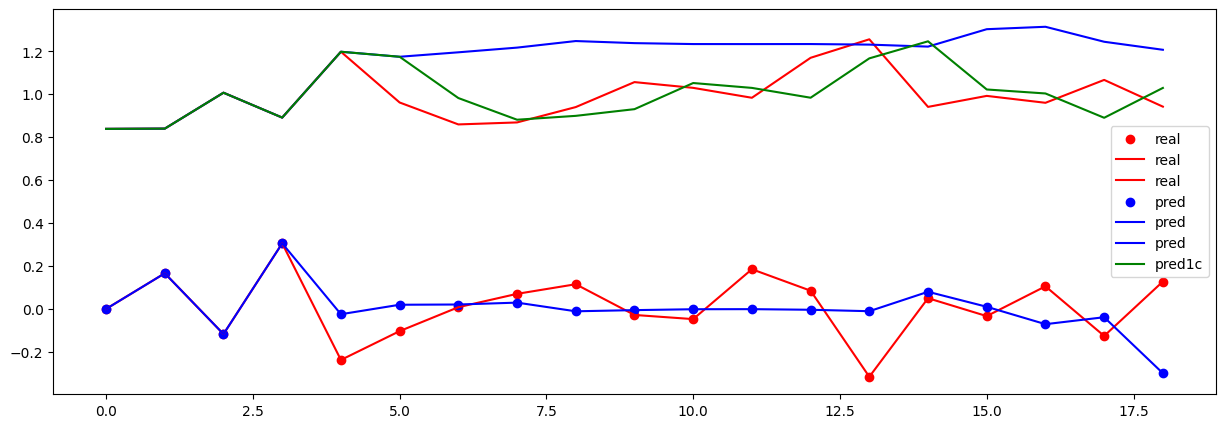

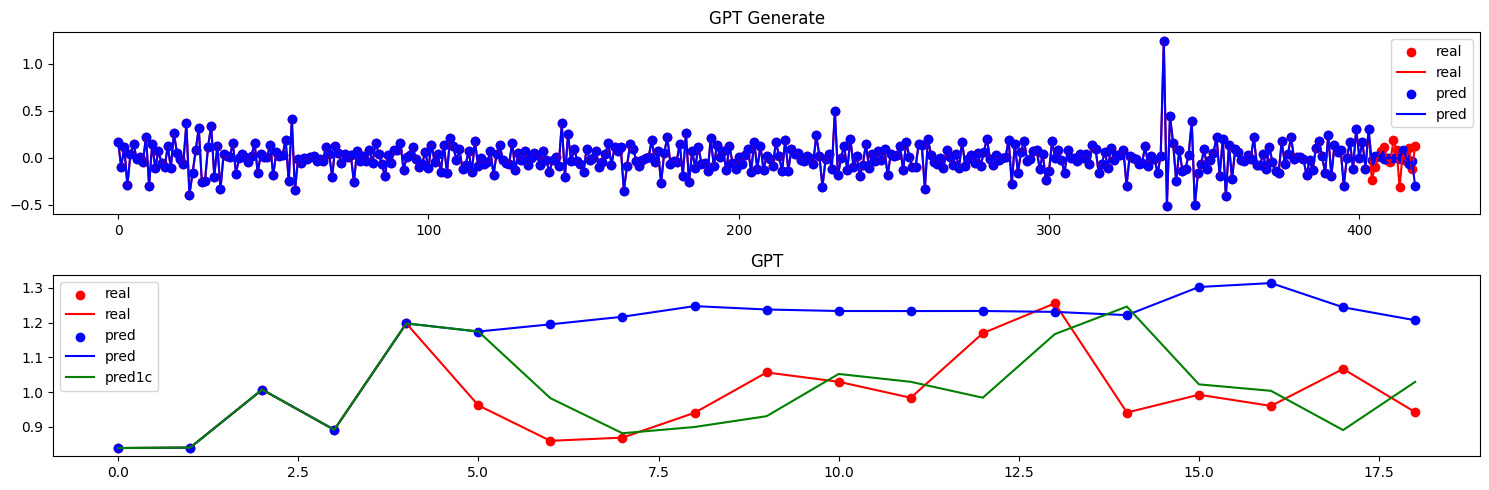

In [104]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



## Run 5


In [105]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
705
1120
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.367282509803772
500 train loss =  0.015367265790700912
1000 train loss =  0.007623206824064255
1500 train loss =  0.004235806409269571
2000 train loss =  0.0034119158517569304
2500 train loss =  0.0029857035260647535


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


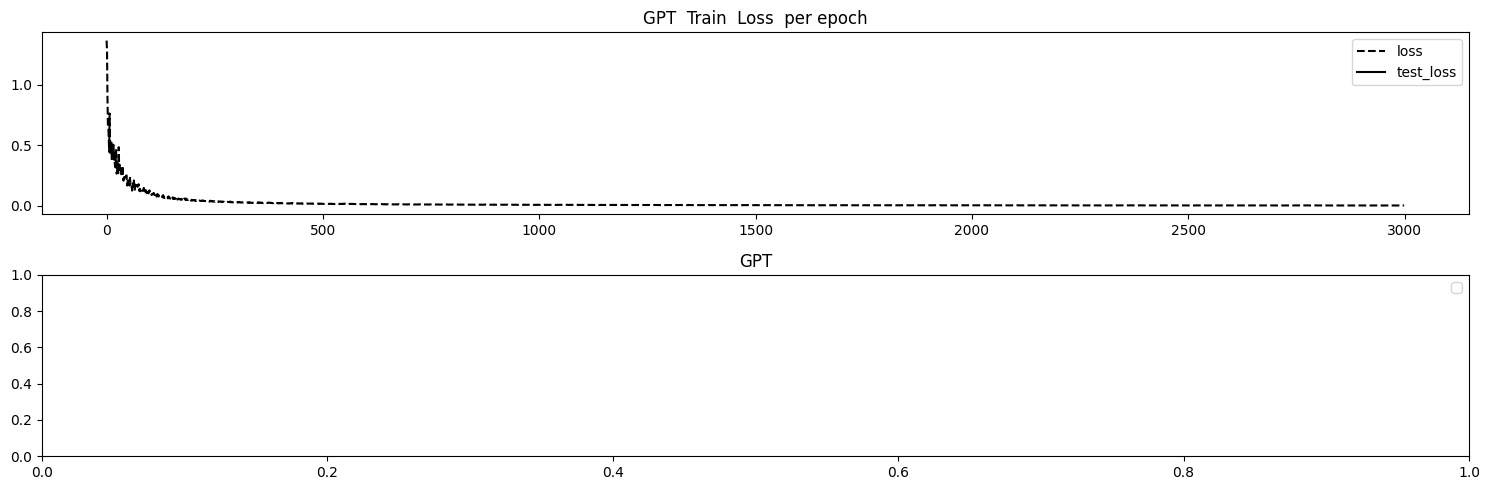

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.02084118127822876
Test MSE Loss - SI only 0-5:  0.039070162922143936
Test MSE Loss - SI only 5-10:  0.011431287974119186
Test MSE Loss - SI only 10-15:  0.020282119512557983
mae, mse, rmse, mape, mspe, rse, corr
(0.11745814, 0.02084118, 0.14436474, 1.1552627, 1.6353655, 1.1701641)
Testing R**2 - SI only:  -0.36928427225715477
Testing R**2 - SI only:  -0.36928427225715477
Testing R**2 - All features:  0.9842974548410575


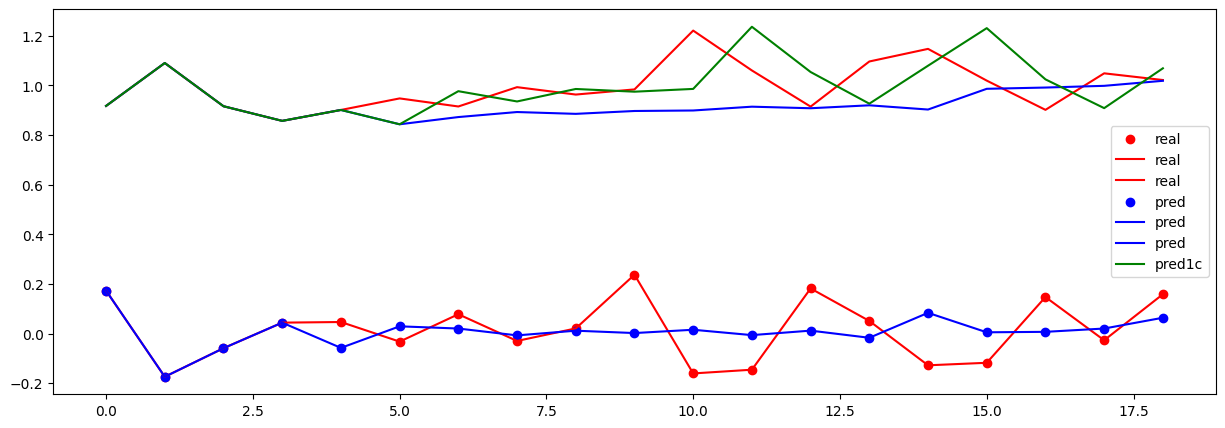

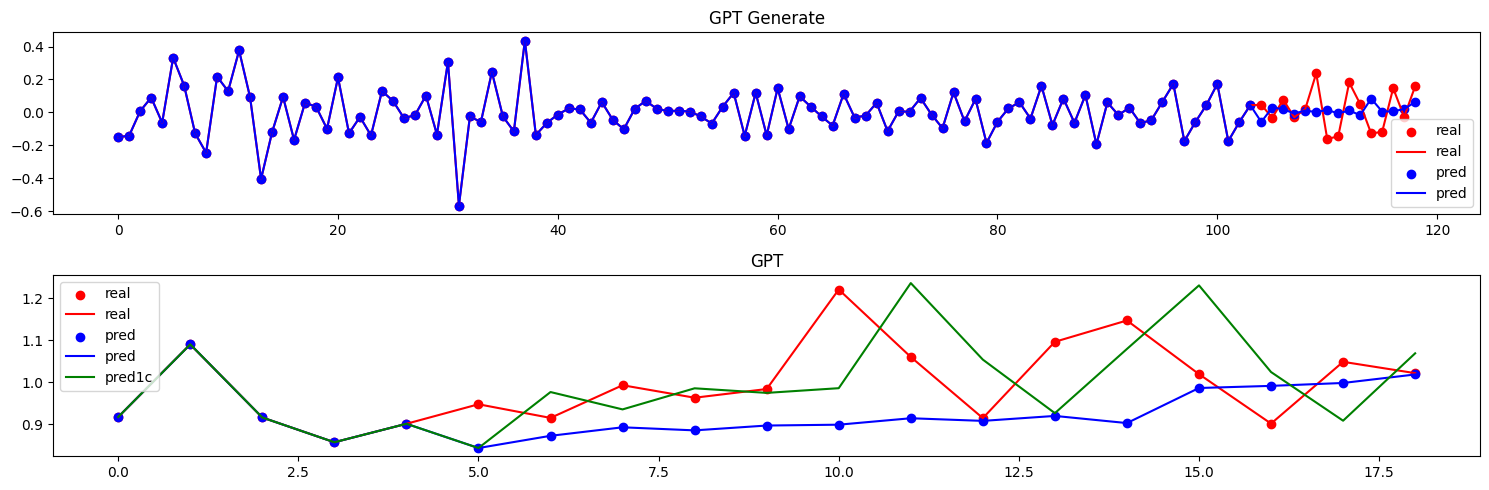

In [106]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  0.965592086315155
500 train loss =  0.042709991335868835
1000 train loss =  0.018328247591853142
1500 train loss =  0.010358202271163464
2000 train loss =  0.006500567775219679
2500 train loss =  0.005658760201185942


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


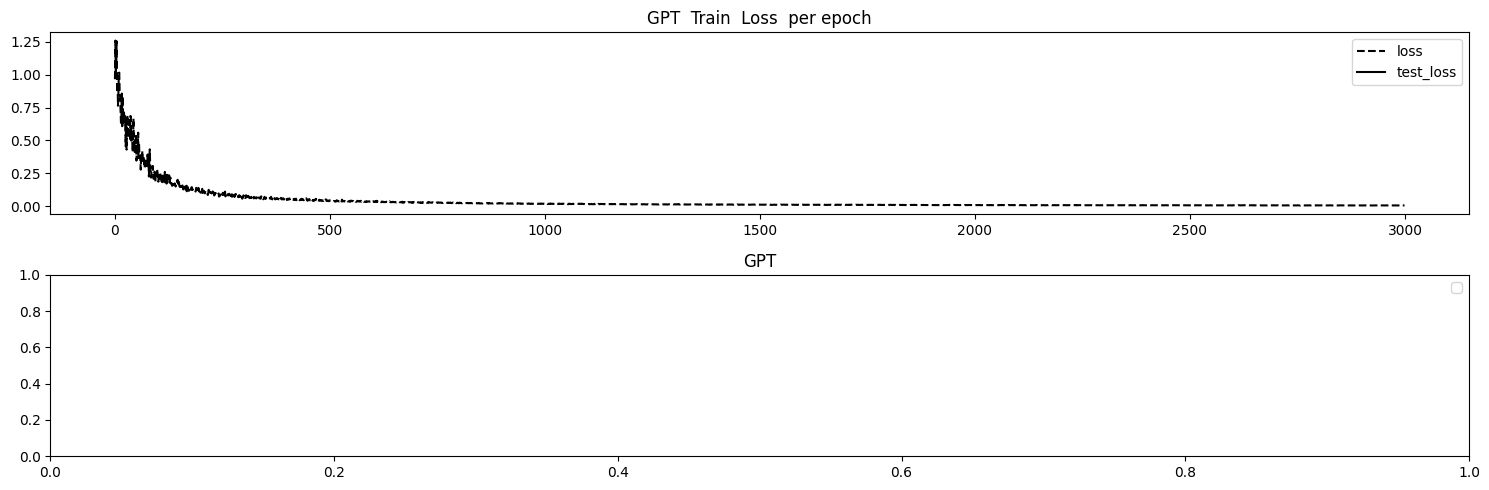

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.020141104236245155
Test MSE Loss - SI only 0-5:  0.03907015547156334
Test MSE Loss - SI only 5-10:  0.01415244024246931
Test MSE Loss - SI only 10-15:  0.017292428761720657
mae, mse, rmse, mape, mspe, rse, corr
(0.11475573, 0.020141102, 0.14191934, 1.1459837, 1.7258462, 1.1503427)
Testing R**2 - SI only:  -0.32328854154831244
Testing R**2 - SI only:  -0.32328854154831244
Testing R**2 - All features:  0.9768156005649671


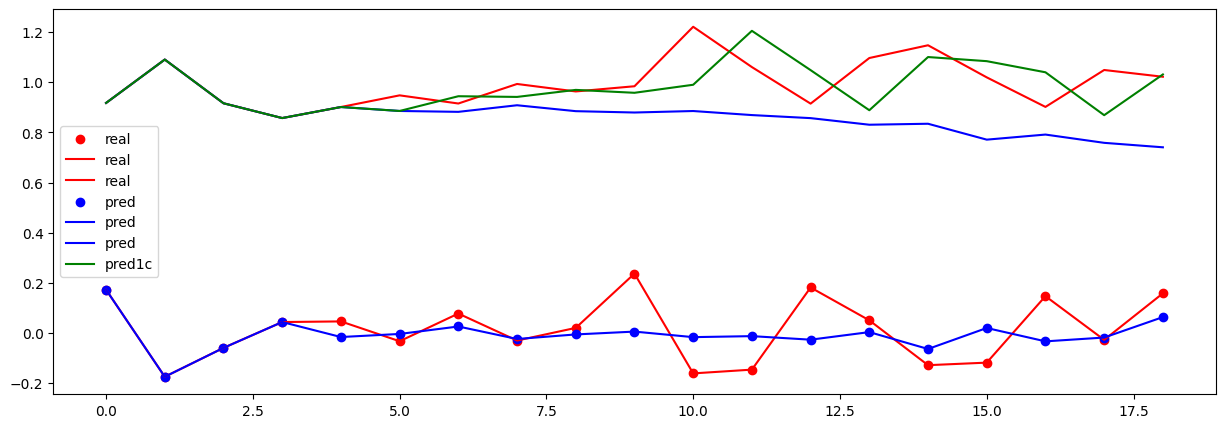

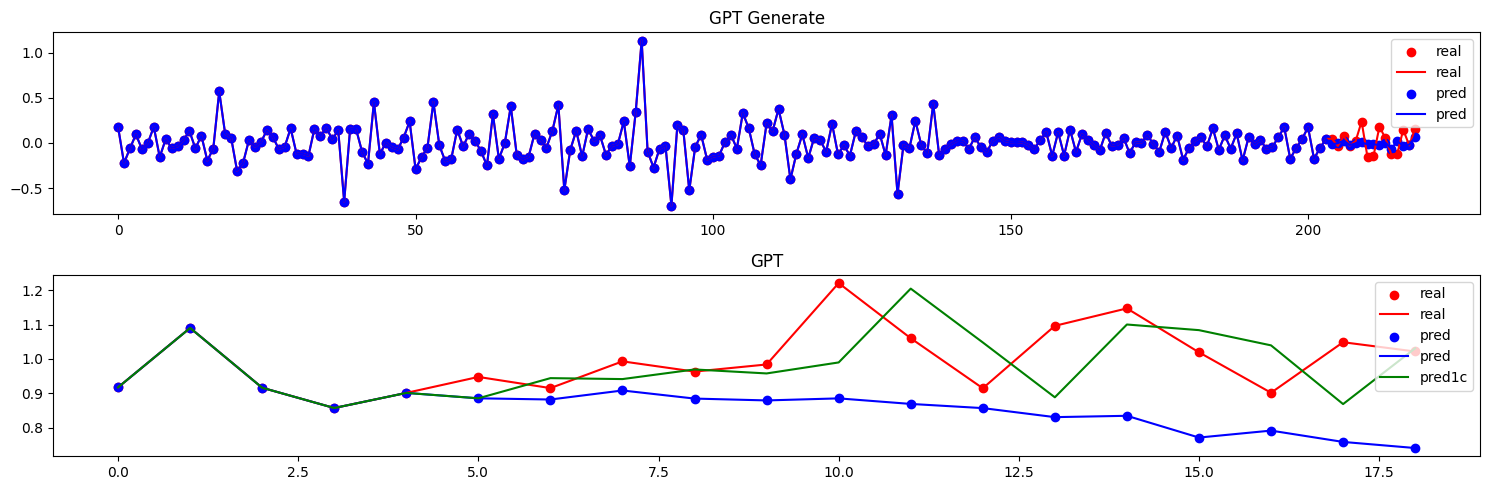

In [107]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.607865810394287
500 train loss =  0.039460357278585434
1000 train loss =  0.019756875932216644
1500 train loss =  0.012143630534410477
2000 train loss =  0.007695591542869806
2500 train loss =  0.006001364439725876


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


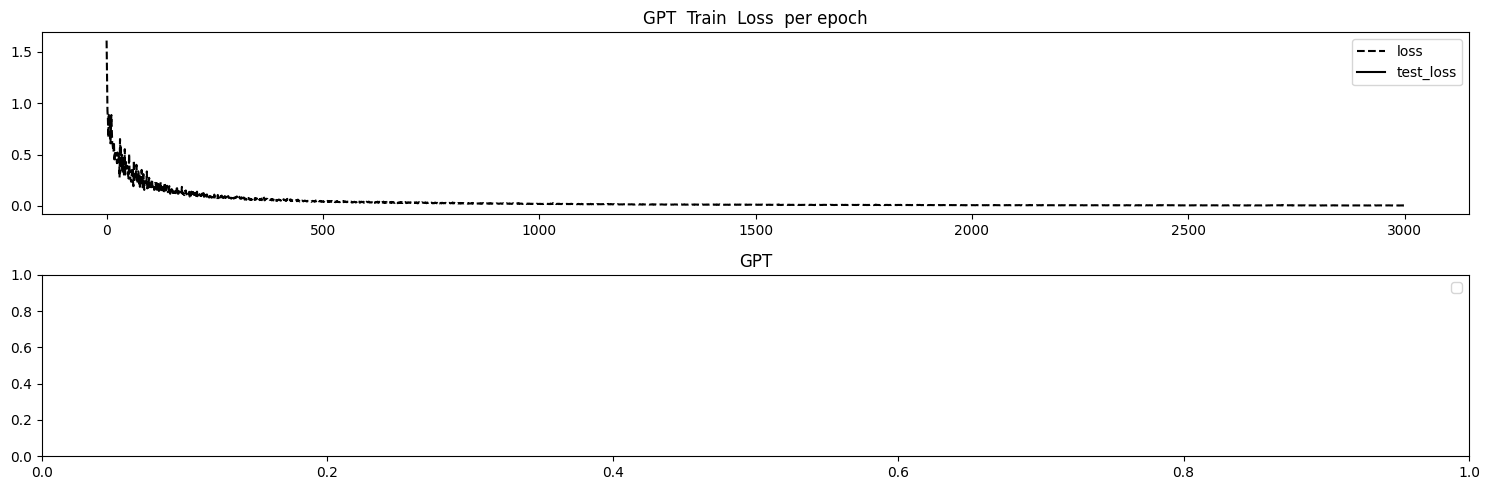

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.022306647151708603
Test MSE Loss - SI only 0-5:  0.03907015547156334
Test MSE Loss - SI only 5-10:  0.016675585880875587
Test MSE Loss - SI only 10-15:  0.020462384447455406
mae, mse, rmse, mape, mspe, rse, corr
(0.12318389, 0.022306647, 0.1493541, 1.2614641, 2.1503658, 1.210606)
Testing R**2 - SI only:  -0.46556677006241154
Testing R**2 - SI only:  -0.46556677006241154
Testing R**2 - All features:  0.9274078174777298


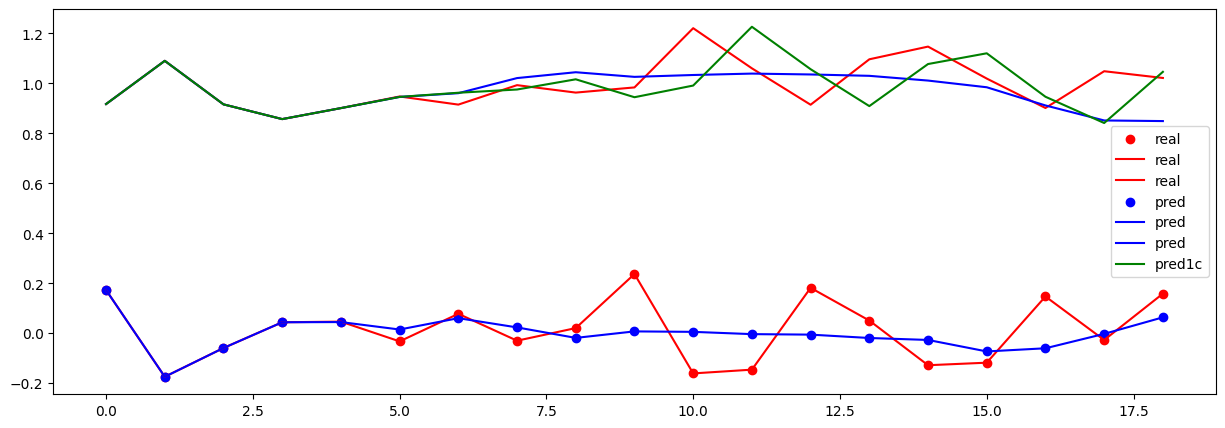

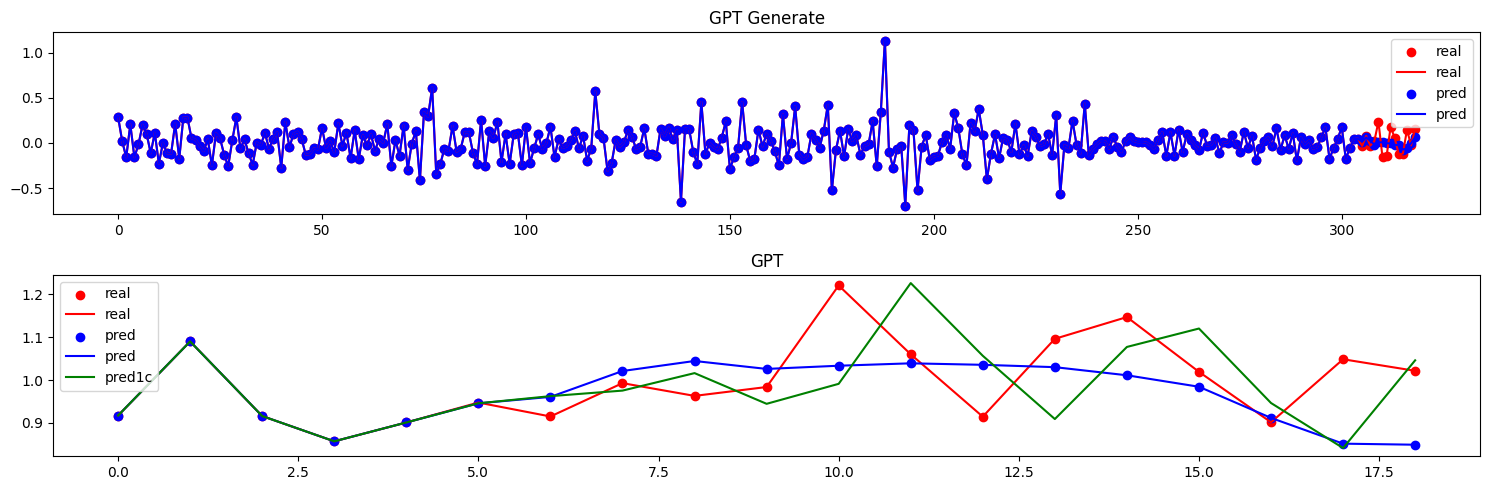

In [108]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.1996327638626099
500 train loss =  0.05778206139802933
1000 train loss =  0.02443048544228077
1500 train loss =  0.013222653418779373
2000 train loss =  0.009937463328242302
2500 train loss =  0.006463932804763317


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


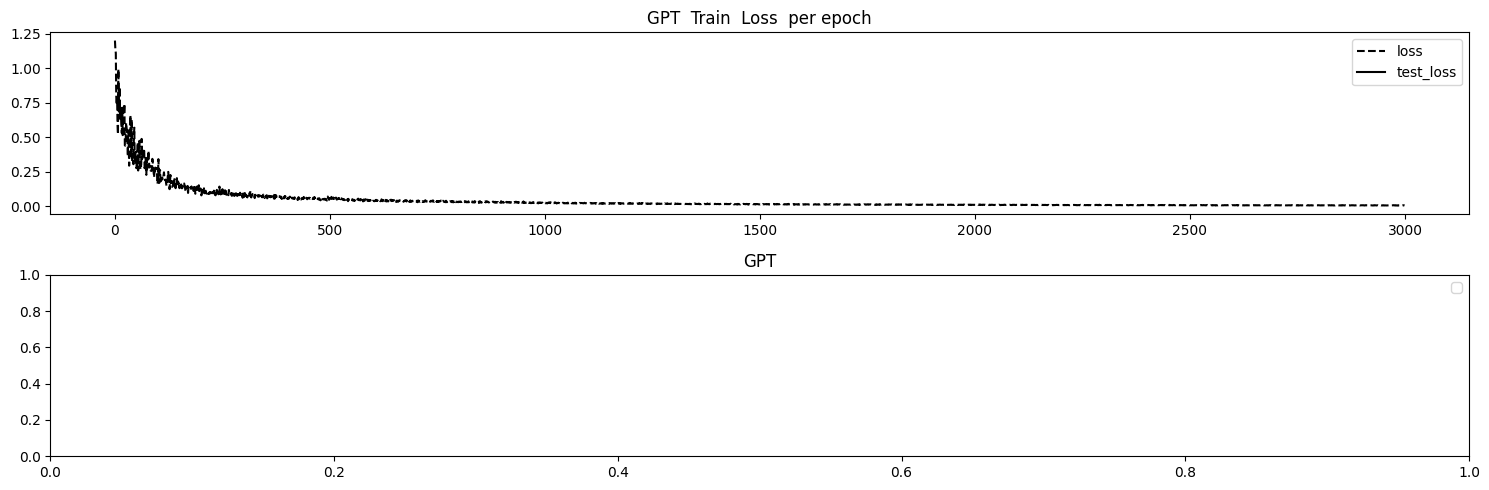

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.021523958072066307
Test MSE Loss - SI only 0-5:  0.03907015547156334
Test MSE Loss - SI only 5-10:  0.01081300713121891
Test MSE Loss - SI only 10-15:  0.022067032754421234
mae, mse, rmse, mape, mspe, rse, corr
(0.12506317, 0.021523962, 0.14671047, 1.4048586, 2.539448, 1.1891778)
Testing R**2 - SI only:  -0.4141435418723596
Testing R**2 - SI only:  -0.4141435418723596
Testing R**2 - All features:  0.9402301441970552


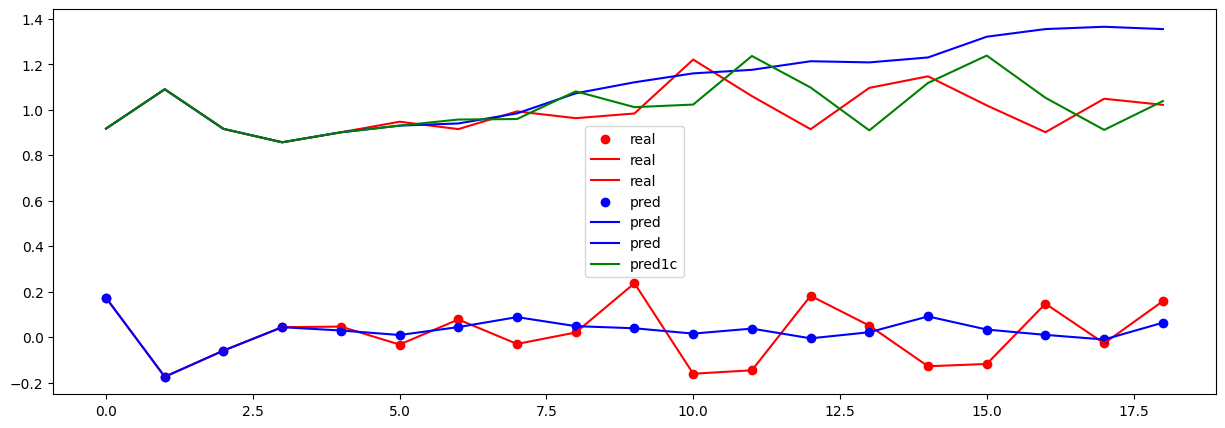

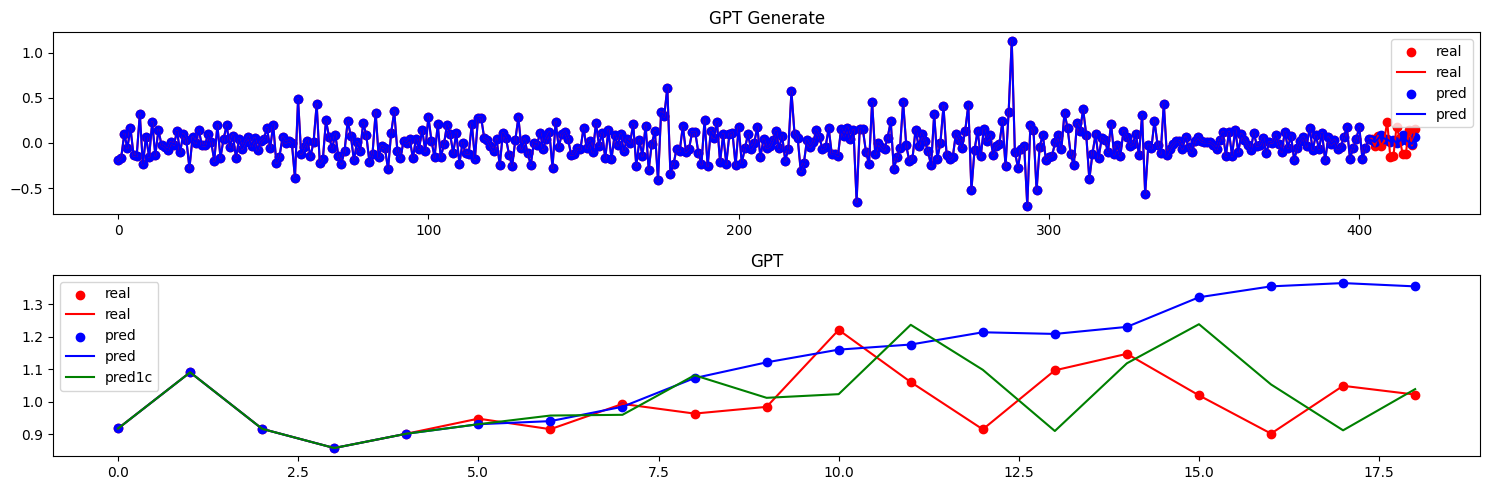

In [109]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 6


In [110]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
216
631
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.2694052457809448
500 train loss =  0.018684281036257744
1000 train loss =  0.00953494943678379
1500 train loss =  0.0066077872179448605
2000 train loss =  0.0043847039341926575
2500 train loss =  0.003354890737682581


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


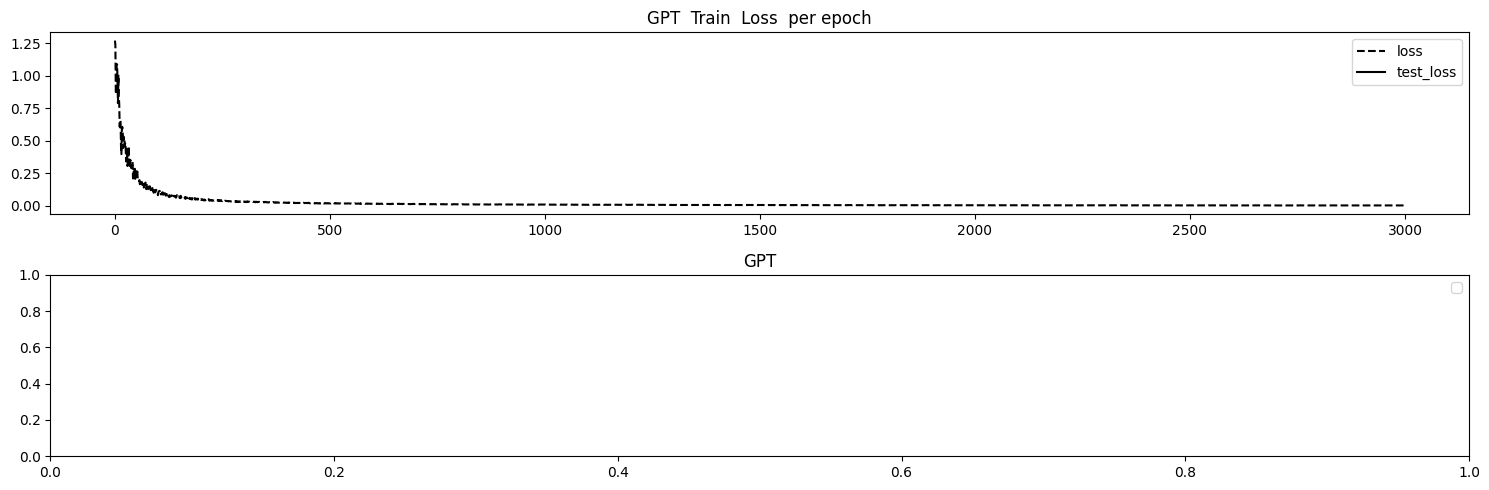

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03333015367388725
Test MSE Loss - SI only 0-5:  0.04587162658572197
Test MSE Loss - SI only 5-10:  0.010242861695587635
Test MSE Loss - SI only 10-15:  0.04423309862613678
mae, mse, rmse, mape, mspe, rse, corr
(0.15402944, 0.03333015, 0.18256547, 2.7684722, 39.982044, 1.284203)
Testing R**2 - SI only:  -0.6491775742377399
Testing R**2 - SI only:  -0.6491775742377399
Testing R**2 - All features:  0.8983456179084373


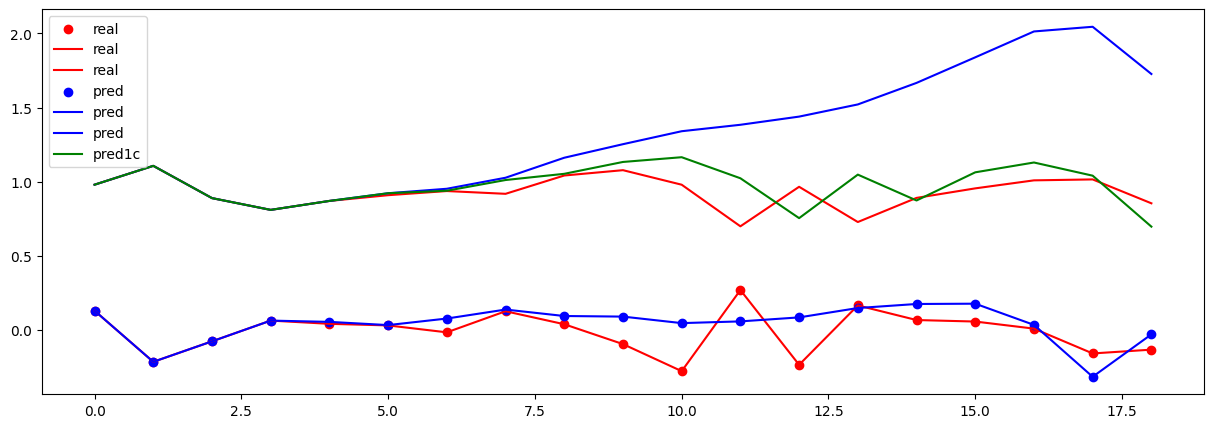

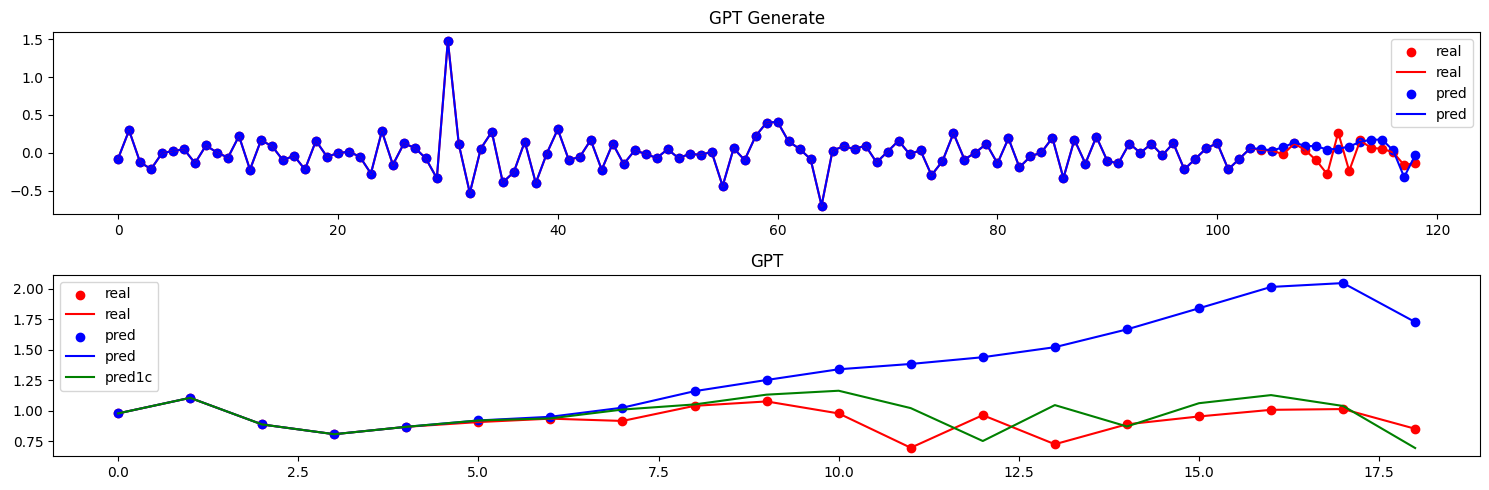

In [111]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.2618601322174072
500 train loss =  0.0328894779086113
1000 train loss =  0.015114949084818363
1500 train loss =  0.00888549629598856
2000 train loss =  0.006150765810161829
2500 train loss =  0.0048705474473536015


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


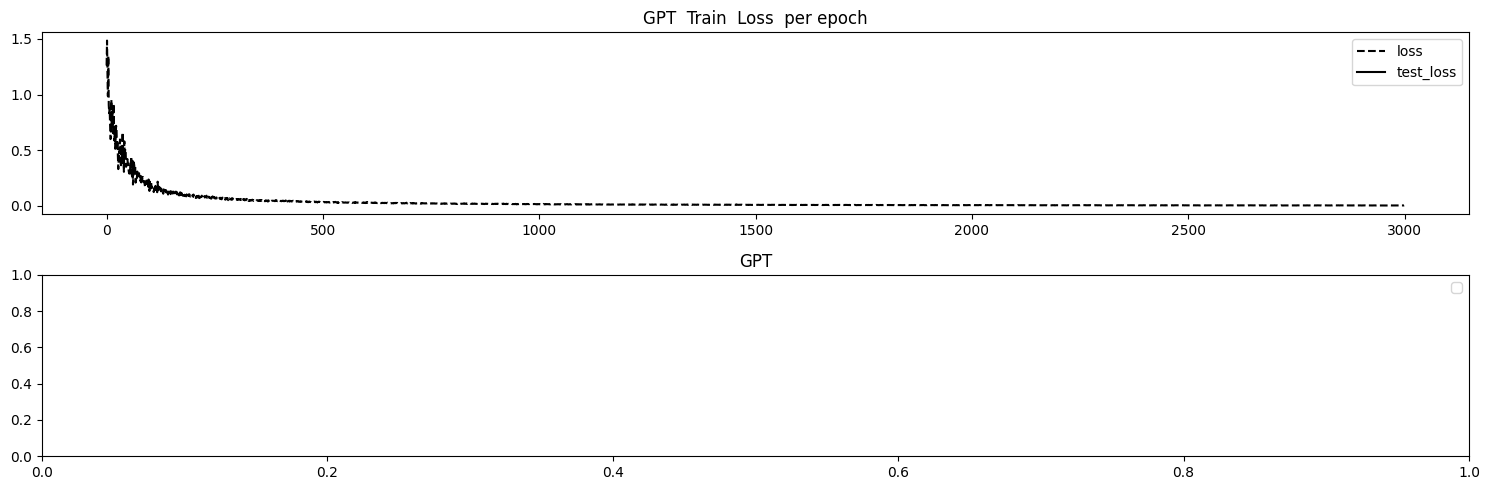

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.026722503826022148
Test MSE Loss - SI only 0-5:  0.04587162658572197
Test MSE Loss - SI only 5-10:  0.004629823844879866
Test MSE Loss - SI only 10-15:  0.0334019809961319
mae, mse, rmse, mape, mspe, rse, corr
(0.13187361, 0.026722504, 0.1634702, 1.2929506, 2.5644295, 1.149883)
Testing R**2 - SI only:  -0.3222309141343158
Testing R**2 - SI only:  -0.3222309141343158
Testing R**2 - All features:  0.9778553249743576


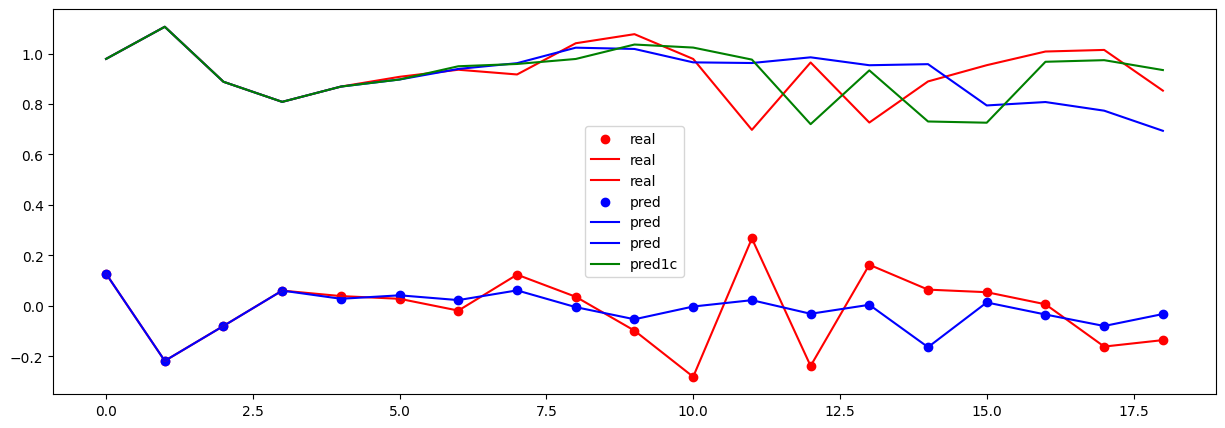

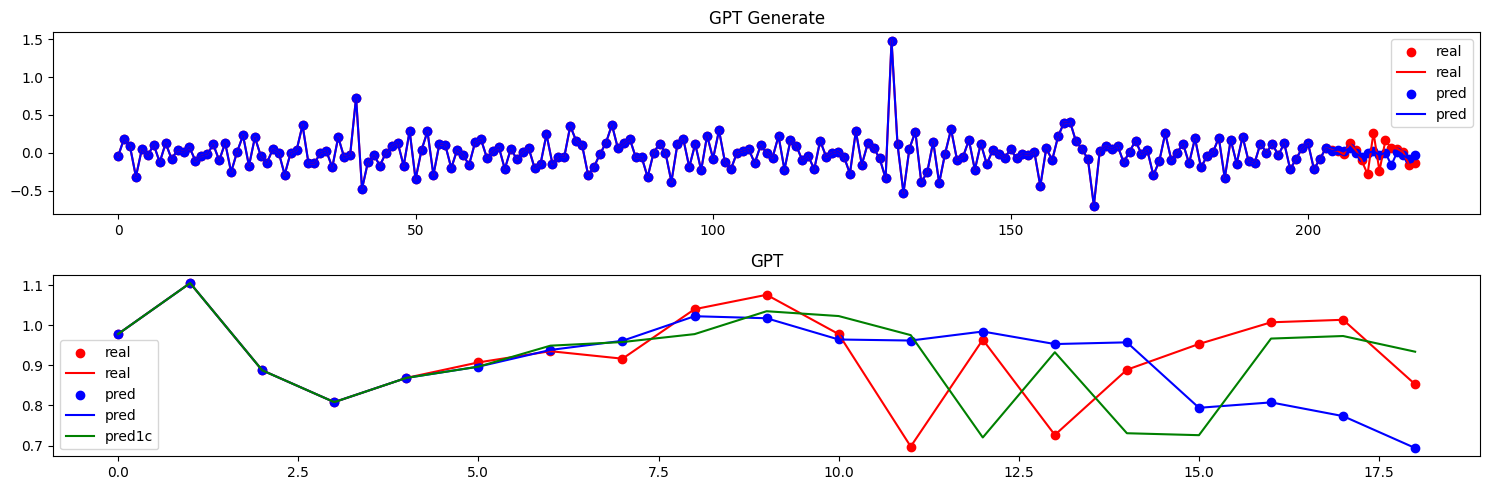

In [112]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.3744641542434692
500 train loss =  0.045205503702163696
1000 train loss =  0.020414046943187714
1500 train loss =  0.011298009194433689
2000 train loss =  0.007595569361001253
2500 train loss =  0.005759525112807751


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


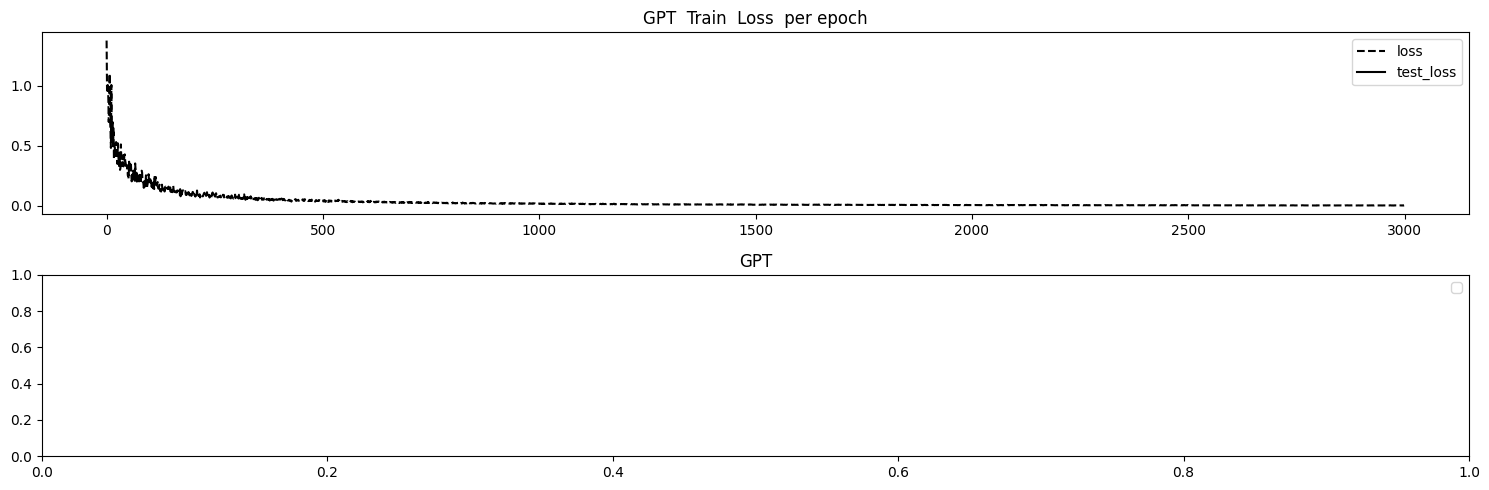

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03696740046143532
Test MSE Loss - SI only 0-5:  0.04587162658572197
Test MSE Loss - SI only 5-10:  0.005380750633776188
Test MSE Loss - SI only 10-15:  0.05461292341351509
mae, mse, rmse, mape, mspe, rse, corr
(0.15553765, 0.036967404, 0.19226909, 1.6841383, 4.943836, 1.3524603)
Testing R**2 - SI only:  -0.8291490123857139
Testing R**2 - SI only:  -0.8291490123857139
Testing R**2 - All features:  0.9500858875911123


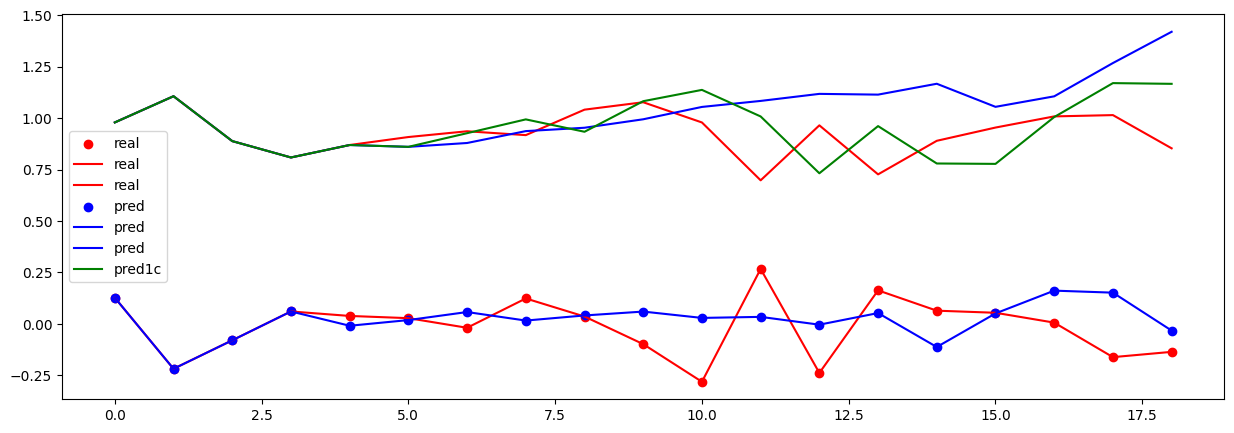

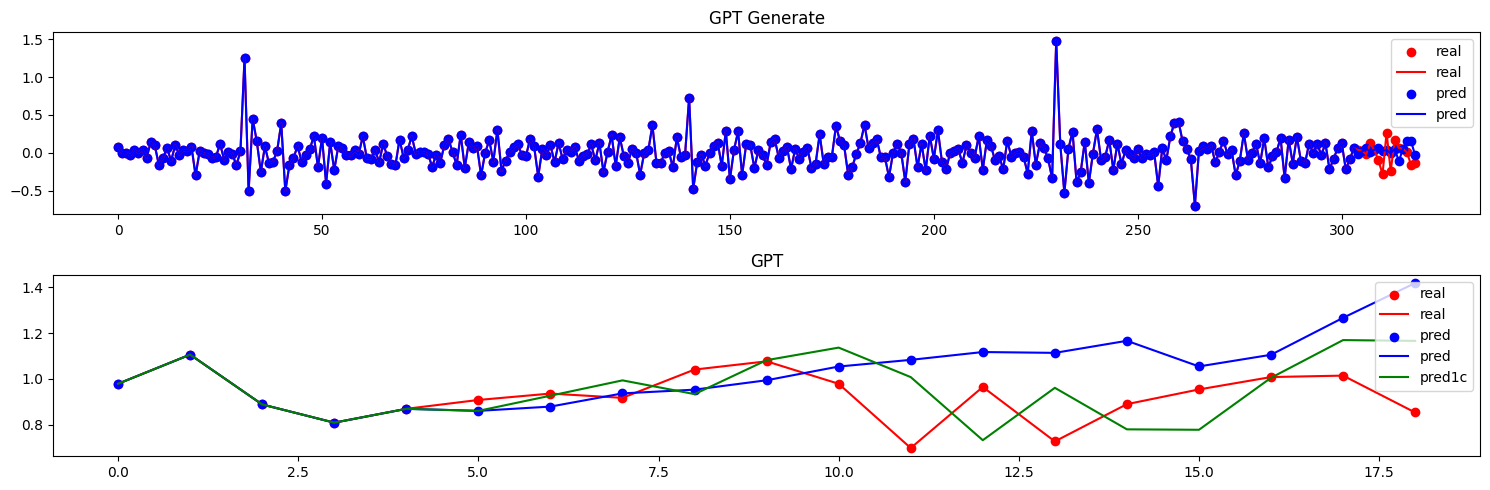

In [113]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.3980141878128052
500 train loss =  0.052397970110177994
1000 train loss =  0.023614486679434776
1500 train loss =  0.013952083885669708
2000 train loss =  0.009803068824112415
2500 train loss =  0.0074278670363128185


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


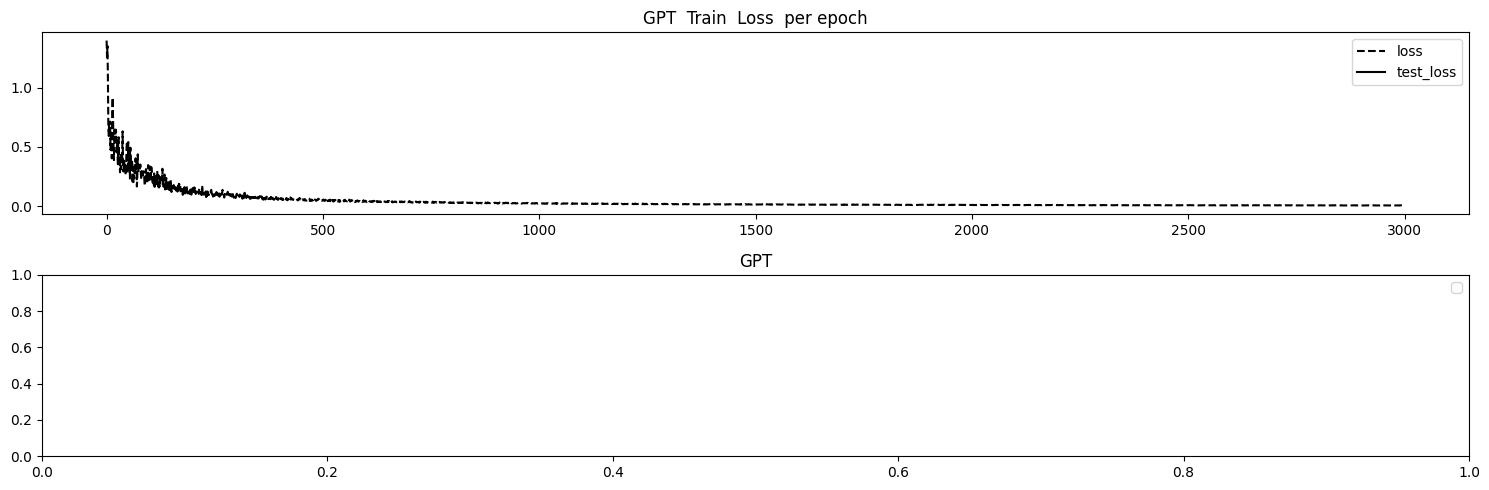

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03412257879972458
Test MSE Loss - SI only 0-5:  0.04587162658572197
Test MSE Loss - SI only 5-10:  0.004636123310774565
Test MSE Loss - SI only 10-15:  0.049020860344171524
mae, mse, rmse, mape, mspe, rse, corr
(0.15452032, 0.03412258, 0.18472297, 3.290635, 87.53314, 1.2993795)
Testing R**2 - SI only:  -0.6883870815926094
Testing R**2 - SI only:  -0.6883870815926094
Testing R**2 - All features:  0.9177111654456476


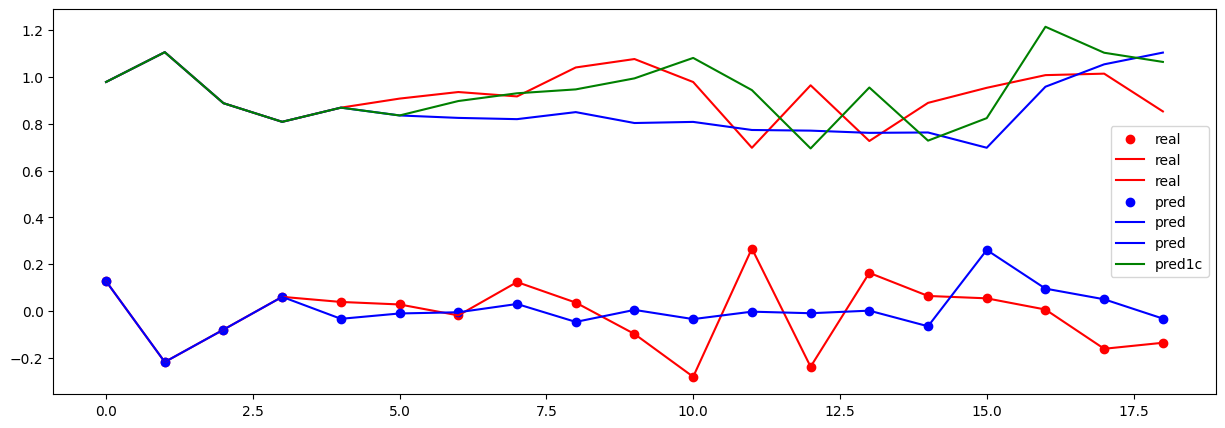

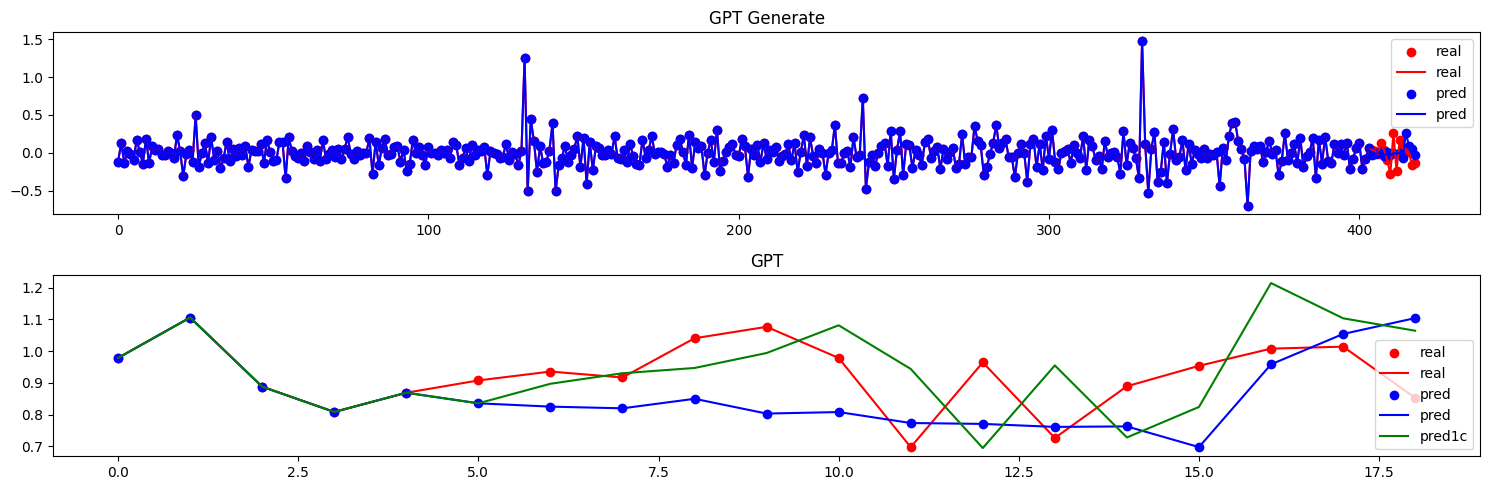

In [114]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()
